# Capstone project by Leonard Veillon
# Shopify e-commerce order predictor

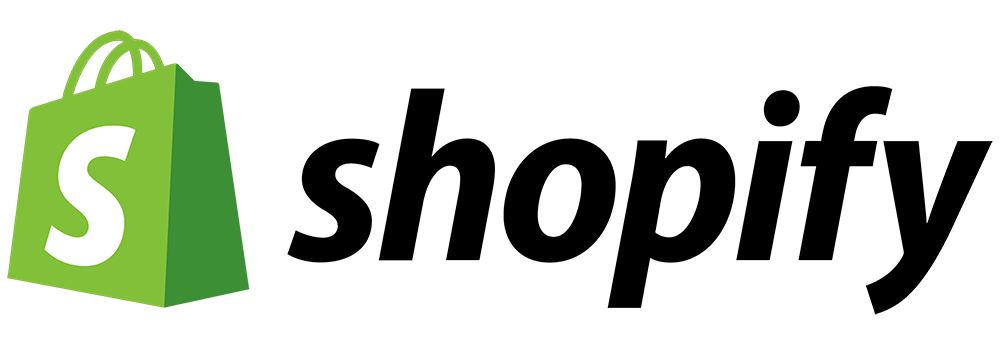

# 1) The problem

Shopify is an e-commerce platform that allows anybody to open an online store and start selling products without any knowledge in web development. The platform handles the data and offers a suite of services on top such as payments, marketing, shipping and customer engagement tools. Today, shopify has nearly 11 percent of the total e-commerce market share with more than a million online stores of all sizes.

The idea of this project is to see if and how machine learning can help small businesses make predictions about future sales using only past behavioral data from online users having visited their store. 

Thanks to automatic data collection from Shopify, every visit on the store is recorder and provides several metrics that can be used as features to build a prediction model.

The particular store we will use for this project is located in Switzerland, sells swiss products internationally since two years, providing around 800 days of data captured on an hourly basis.

**Model**  
The **binary target variable** is whether or not an order is placed following a visit on the store.  `y = {0,1}`  
We will take all visits on the store with the available features and train models to try to predict y.  
A beseline model willl be generated and compared to models made with kNN / Random Forest / Logistic Regression.

**Scoring Metric**  
In E-Commerce, only around 3% of visits are converted (generate orders). This creates a heavily imbalanced data set. In order to handle that, we will not look at the accuracy of the prediction - since always predicting '0' gives a accuracy of 97% - but at the **f1 score** which combine the precision and recall scores of these prediction.

# 2) The data
## (a) Overview of your data

Source: The data comes from the report page of the analytics tab of the Shopify store:  
[Shop Name].myshopify.com/admin/reports/sessions_over_time

Every hour, shopify summarizes what happened on the store and adds it to the database as new rows.

- Rows are aggregated per feature.
- Users that share the same features have their data aggregated and averaged. 

As a simple example, taking only the features `hour` / `location_country` / `device` / `avg_duration`.  

- 3 people visiting the store at 11:00 from Lausanne.
- The first two users are on their mobile, the third one on a desktop
- They all spent 30 sec on the site  

The added rows will look like this:

| Index | hour  | location | device  | Visitors | avg_duration |
|-------|-------|----------|---------|----------|--------------|
| 1     | 11:00 | LAUSANNE | MOBILE  | 2        | 30           |
| 2     | 11:00 | LAUSANNE | DESKTOP | 1        | 30           |
|       |       |          |         |          |              |

Adding all the features, it is rare that a row concerns more than one user but it happens sometimes and create most of the time outliers.

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns

### data
data = pd.read_csv('data/data.csv')
print('Shape: ', data.shape)
data.tail(5)

Shape:  (25787, 20)


,hour,referrer_source,referrer_name,ua_form_factor,page_type,page_url,location_country,location_region,location_city,page_path,referrer_url,referrer_host,total_visitors,total_carts,total_checkouts,total_orders_placed,total_pageviews,total_sessions,avg_duration,total_bounce_rate
25782,2021-05-27 11:00:00,Direct,NaN,Mobile,Homepage,https://[shop_name]/,Switzerland,Zurich,Zurich,NaN,NaN,NaN,1,0,0,0,3,1,24s,0.0
25783,2021-01-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0s,0.0
25784,2020-02-11 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0s,0.0
25785,2020-08-24 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0s,0.0
25786,2021-05-04 11:00:00,Direct,NaN,Mobile,Homepage,https://[shop_name]/,France,NaN,NaN,NaN,NaN,NaN,1,0,0,0,3,1,16s,0.0


### Type of data

#### Continuous
- **hour:** Date with hour - ex. 2021-10-11 20:00:00
- **page_views:** Number of pages visited by the users     
- **avg_duration:**  Average duration of all sessions made by the visitors [sec]

#### Discrete
- **bounce_rate:** Percentage of visitors that stayed on the site or left.
- **visitors:** Number of different visitors that reached the store on a specific hour.
- **sessions:** Number of sessions made by the visitors. A visitor can have multiple sessions.
- **carts:**  Number of carts that were filled      
- **checkouts:** Number of times visitors reached the checkout      
- **orders_placed:**  Number of orders placed

#### Categorical
- **referrer_source:** Type of referer - ['Direct', 'Social', 'Search', 'Unknown', 'Email']   
- **referrer_name:** Name of referer - ex. Google, Facebook, etc.
- **referrer_host:** Short url
- **referrer_url:** Complete url      
- **ua_form_factor:** Type of device used - ['Desktop', 'Mobile', 'Other', 'Tablet']
- **page_type:** Type of page reached on the store - ex. Homepage, Product, Cart, etc.      
- **page_url:** Complete url
- **page_path:** Path from the store url       
- **country:** Country where users are located
- **region:** Region in the Country where users are located
- **city:** City where users are located

## Data Preparation
### Clean data 

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25787 entries, 0 to 25786
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hour                 25787 non-null  object 
 1   referrer_source      12725 non-null  object 
 2   referrer_name        5290 non-null   object 
 3   ua_form_factor       12725 non-null  object 
 4   page_type            12686 non-null  object 
 5   page_url             12725 non-null  object 
 6   location_country     12321 non-null  object 
 7   location_region      10128 non-null  object 
 8   location_city        9538 non-null   object 
 9   page_path            4744 non-null   object 
 10  referrer_url         7115 non-null   object 
 11  referrer_host        7115 non-null   object 
 12  total_visitors       25787 non-null  int64  
 13  total_carts          25787 non-null  int64  
 14  total_checkouts      25787 non-null  int64  
 15  total_orders_placed  25787 non-null 

In [3]:
#All rows with `visitors == 0` are the hours without visits. we will delete them as these rows bring no information.
data = data.drop(index=data[data['total_visitors'] == 0].index)

# Correct cart == 0 & orders_placed == 1
# If you placed an order, there was something in the cart

indexes = data.query('total_carts == 0 & total_orders_placed == 1').index
data.loc[indexes, 'total_carts'] = 1

# Correct bounce_rate == 1 & orders_placed == 1
# If you placed an order, you stayed on the site

indexes = data.query('total_bounce_rate == 1 & total_orders_placed == 1').index
data.loc[indexes, 'total_bounce_rate'] = 0

# Rename columns
def clean_data(data):
    # Rename
    data.rename(columns={'ua_form_factor': 'device', 'location_country': 'country', 'location_region': 'region',
                     'location_city': 'city', 'total_bounce_rate': 'bounce_rate',
                     'total_visitors': 'visitors', 'total_carts': 'carts', 'total_checkouts': 'checkouts',
                    'total_orders_placed': 'orders_placed', 'total_pageviews': 'page_views',
                    'total_sessions': 'sessions', 'hour': 'datetime'}, inplace=True)

    # Sort values
    data.sort_values(by=["datetime"], ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)

    # correct datetime
    data['datetime'] = pd.to_datetime(data['datetime'])

    ### Correct avg_duration
    # Seconds
    data['avg_duration'] = data['avg_duration'].str.replace('s', '')
    correct_time = lambda x: pd.Series([i for i in reversed(x.split('m'))])
    temp = data['avg_duration'].apply(correct_time)
    temp.rename(columns={0: 'seconds', 1: 'minutes'}, inplace=True)
    temp.fillna(0, inplace=True)

    # Minutes / Hours
    temp['minutes'] = temp['minutes'].astype(str)
    correct_time2 = lambda x: pd.Series([i for i in reversed(x.split('h'))])
    temp2 = temp['minutes'].apply(correct_time2)
    temp2.rename(columns={0: 'minutes', 1: 'hours'}, inplace=True)
    temp2.fillna(0, inplace=True)

    # Combine
    temp[['minutes','hours']] = temp2[['minutes','hours']]
    temp['seconds'] = pd.to_numeric(temp['seconds'])
    temp['minutes'] = pd.to_numeric(temp['minutes'])
    temp['hours'] = pd.to_numeric(temp['hours'])
    temp['duration'] = temp['hours'] * 3600 + temp['minutes'] * 60 + temp['seconds']

    # Reverse bounce rate: 0 leaves, 1 stays
    data['bounce_rate'] = 1 - data['bounce_rate']

    # Replace database values
    data['avg_duration'] = temp['duration']

    ### Change columns order
    column_names = ['datetime', 'referrer_source', 'referrer_name', 'referrer_host', 'referrer_url', 'device', 'page_type',
           'page_url', 'page_path', 'country', 'region', 'city', 'visitors', 'sessions', 'page_views', 'carts',
                    'checkouts', 'avg_duration', 'bounce_rate', 'orders_placed']

    data = data.reindex(columns=column_names)

    ### Show data
    return data

- Remove visitor == 0
- Page views
- Average duration
- bounce rate
- datetime
- Change orger

In [4]:
data  = clean_data(data)
data.tail()

,datetime,referrer_source,referrer_name,referrer_host,referrer_url,device,page_type,page_url,page_path,country,region,city,visitors,sessions,page_views,carts,checkouts,avg_duration,bounce_rate,orders_placed
12720,2021-10-27 22:00:00,Search,Google,www.google.com,www.google.com,Mobile,Custom Page,https://[shop_name]/pages/[keyword_10]-[keywor...,/pages/[keyword_10]-[keyword_4]-a-[keyword_24],Switzerland,Vaud,Lausanne,1,1,1,0,0,0.0,0.0,0
12721,2021-10-27 22:00:00,Direct,NaN,NaN,NaN,Mobile,Homepage,https://[shop_name]/,NaN,Switzerland,Geneve,Geneve,1,1,10,1,1,369.0,1.0,1
12722,2021-10-27 22:00:00,Search,Google,www.google.com,www.google.com,Mobile,Homepage,https://[shop_name]/,NaN,United Kingdom,Croydon,Croydon,1,1,7,1,0,281.0,1.0,0
12723,2021-10-27 22:00:00,Search,Google,www.google.com,www.google.com,Mobile,Homepage,https://[shop_name]/,NaN,Switzerland,Zurich,Schlieren,1,1,3,0,0,103.0,1.0,0
12724,2021-10-27 23:00:00,Social,Instagram,l.instagram.com,l.instagram.com,Mobile,Homepage,https://[shop_name]/,NaN,United States,Texas,Dallas,1,1,1,0,0,0.0,0.0,0


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
visitors,12725.0,1.044558,0.280024,1.0,1.0,1.0,1.0,8.0
sessions,12725.0,1.047859,0.285599,1.0,1.0,1.0,1.0,8.0
page_views,12725.0,2.939332,3.452525,1.0,1.0,1.0,4.0,58.0
carts,12725.0,0.068134,0.251985,0.0,0.0,0.0,0.0,1.0
checkouts,12725.0,0.065147,0.247431,0.0,0.0,0.0,0.0,2.0
avg_duration,12725.0,118.217675,377.288411,0.0,0.0,0.0,71.0,10577.0
bounce_rate,12725.0,0.441401,0.495656,0.0,0.0,0.0,1.0,1.0
orders_placed,12725.0,0.035285,0.184506,0.0,0.0,0.0,0.0,1.0


In [6]:
data.describe(include=['O']).T

,count,unique,top,freq
referrer_source,12725,5,Direct,6668
referrer_name,5290,14,Google,3510
referrer_host,7115,95,www.google.com,2570
referrer_url,7115,250,www.google.com,2537
device,12725,4,Mobile,7958
page_type,12686,10,Homepage,7981
page_url,12725,1174,https://[shop_name]/,5810
page_path,4744,42,/products/[keyword_6],1067
country,12321,80,France,4685
region,10128,248,Île-de-France,1029


In [7]:
print('Proportion of no order/orders:')
data['orders_placed'].value_counts(normalize=True)

Proportion of no order/orders:


0    0.964715
1    0.035285
Name: orders_placed, dtype: float64

### Quality of the data
- There are NaN values only in the categorical features.
- There are outliers especially with merged visits.
- Only 5% (mean of carts) of visits result in the cart being filled and 3.5% in an order being placed. We have indeed **"Class Imbalance"**.
- Data is heavily left skewed and should need some regularization.

## Plan to manage and process the data

1. Data cleaning
    - NaN: Categorical NaN values will be handled using the mode from the parent category.  
    - Outliers: Check distribution of data and remove outliers.  
    - Useless features: Once cleaned, some categorical features will end up useless as they will share the same information with other features. We will delete them.
2. Regularization:
    - Numerical data is heavily left skewed and need some regularization.  
3. Feature engineering:  
    - We will add new features based on Datetime: `year`, `month`, `day_of_week`, `hour_of_day`, `day_of_month`
    - We will add shipping cost and import legal restrictions.

# 3) Exploratory data analysis (EDA)

## (a) Preliminary EDA

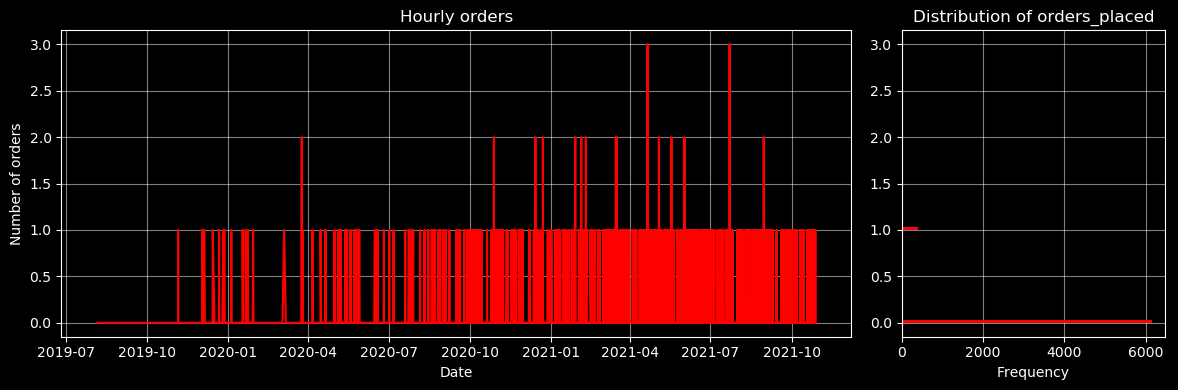

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Matplotlib params
plt.rcParams['figure.dpi']= 100
plt.rc('axes', axisbelow=True)
plt.style.use('dark_background')

# Get data
df = data.pivot_table(index='datetime', aggfunc='sum')
df.fillna(0, inplace=True)
orders = df['orders_placed']

# Graph
fig, ax = plt.subplots(1,2,figsize=(12, 4),gridspec_kw={'width_ratios': [3, 1]})

# create the first plot for the orders over time
ax[0].set_title('Hourly orders')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of orders')
ax[0].grid(alpha=.5)
ax[0].plot(orders, c='r')

# create the histogram of orders in the second plot
ax[1].set_title('Distribution of orders_placed')
ax[1].set_xlabel('Frequency')
ax[1].hist(orders,bins=90,orientation='horizontal', color='r')
ax[1].grid(alpha=.5)

fig.tight_layout()
plt.show()

Sometimes, more than 1 order is made during an hour. Unfortunatelly, these samples are outliers that need to be deleted.  
On the right chart, on the distribution of `orders_placed`, we see how imbalanced the target is.

## Data cleaning
### Missing Values

In [9]:
print('Missing values\n')
data.isnull().sum()

Missing values



datetime              0
referrer_source       0
referrer_name      7435
referrer_host      5610
referrer_url       5610
device                0
page_type            39
page_url              0
page_path          7981
country             404
region             2597
city               3187
visitors              0
sessions              0
page_views            0
carts                 0
checkouts             0
avg_duration          0
bounce_rate           0
orders_placed         0
dtype: int64

- Use the most common country for missing `country`.  
- Same for `region` with most common region from the same country.
- Same for `city` with most common city from the same region. 

In [10]:
# Fill NaN Country with Country Mode
countries_indexes = data[data['country'].isnull()].index
data.loc[countries_indexes, 'country'] = data['country'].mode()[0]

# Fill NaN Regions with Mode from Country
regions_indexes = data[data['region'].isnull()].index

for i in regions_indexes:
    country = data.iloc[i]['country']  
    temp = data[data['country'] == country]['region'].mode()
    if len(temp) == 0:
        country_region_mode = np.nan
    else:
        country_region_mode = temp[0] # Use first region if mode > 1
        
    data.at[i,'region']= country_region_mode

# Fill NaN cities with Mode from Region
cities_indexes = data[data['city'].isnull()].index

for i in cities_indexes:
    region = data.iloc[i]['region']  
    temp = data[data['region'] == region]['city'].mode()
    if len(temp) == 0:
        region_city_mode = np.nan
    else:
        region_city_mode = temp[0] # Use first city if mode > 1
        
    data.at[i,'city']= region_city_mode

In [11]:
data[data['city'].isnull()]['country'].value_counts()

Singapore                 26
Iran                      26
Tunisia                    3
Cameroon                   2
Egypt                      1
Guadeloupe                 1
Réunion                    1
Bosnia and Herzegovina     1
Niger                      1
Georgia                    1
Japan                      1
New Caledonia              1
Name: country, dtype: int64

There are still some missing values that we will fill manually.

In [12]:
# Fill remaining NaN by creating a dict with capitals from Countries. France is added to fill a NaN in Lorraine

dict_regions = {'Tunisia': 'Tunis', 'Réunion': 'Saint-Denis', 'Monaco': 'Monaco', 'Iran': 'Tehran', 'Cameroon': 'Yaoundé', 'Egypt': 'Carop',
       'Guadeloupe': 'Basse-Terre', 'Jersey': 'Saint-Helier', 'Martinique': 'Fort-de-France', 'Bosnia and Herzegovina': 'Sarajevo',
       'Japan': 'Tokyo', 'Madagascar': 'Tananarive', 'French Guiana': 'Cayenne', 'Georgia': 'Tbilissi', 'Singapore': 'Singapore',
       'Niger': 'Niamey', 'France': 'Nancy', 'New Caledonia': 'Nouméa'}

# Fill remaining NaN Regions
regions_indexes = data[data['region'].isnull()].index

for i in regions_indexes:
    country = data.iloc[i]['country']  
    region = dict_regions[country]
        
    data.at[i,'region']= region

# Fill remaining NaN Cities
cities_indexes = data[data['city'].isnull()].index

for i in cities_indexes:
    country = data.iloc[i]['country']  
    region = dict_regions[country]
    data.at[i,'city']= region

##### Missing data in `referrer` features

In [13]:
data['referrer_name'].value_counts()

Google        3510
Facebook      1150
Instagram      403
Bing            76
DuckDuckGo      67
Ecosia          46
Yahoo!          16
Yandex           6
Twitter          6
Pinterest        4
Gmail            2
Messenger        2
LinkedIn         1
Snapchat         1
Name: referrer_name, dtype: int64

In [14]:
print(data[data['referrer_name'].isnull()]['referrer_source'].mode()[0])
print(data[data['referrer_source'] == 'Direct']['referrer_name'].value_counts())

Direct
Series([], Name: referrer_name, dtype: int64)


Most missing `referrer_name` have users coming directly on the site, we will fill these NaN with 'Direct', the same value.  
All rows with 'Direct' as `referrer_source` have only NaNs as `referrer_name`. It is consistent.

In [15]:
# Fill NaN referrer_name with `Direct`
referrer_name_indexes = data[data['referrer_name'].isnull()].index
data.loc[referrer_name_indexes,'referrer_name'] = data[data['referrer_name'].isnull()]['referrer_source'].mode()[0] # Mode is `Direct`

##### Page host and page url

In [16]:
print(data[data['referrer_host'].isnull()]['referrer_source'].mode()[0])

Direct


Missing `referrer_host` and `referrer_url` are **only** people coming directly on the site. We will fill them with 'Direct'.

In [17]:
# Fill NaN referrer_host with `Direct`
referrer_host_indexes = data[data['referrer_host'].isnull()].index
data.loc[referrer_host_indexes,'referrer_host'] = data[data['referrer_host'].isnull()]['referrer_source'].mode()[0] # Mode is `Direct`
    
# Fill NaN referrer_url with `Direct`
referrer_url_indexes = data[data['referrer_url'].isnull()].index
data.loc[referrer_url_indexes,'referrer_url'] = data[data['referrer_url'].isnull()]['referrer_source'].mode()[0] # Mode is `Direct`

##### Page type

In [18]:
data[data['page_type'].isnull()]['page_url'].value_counts()

https://[shop_name]/404                               23
https://[shop_name]/en                                 2
https://[shop_name]/404?fbclid=IwAR1sPujDvqYOmA3iF     1
https://[shop_name]/404?fbclid=IwAR0Q_Sw4odGXVZXxY     1
https://[shop_name]/404?fbclid=IwAR06emBttObFA4O8C     1
https://[shop_name]/404?fbclid=IwAR1y846xd9zuJyFL2     1
https://[shop_name]/404?fbclid=IwAR3Bw64PVtswJ943C     1
https://[shop_name]/404?fbclid=IwAR1XlPtyJ6-yJAx3J     1
https://[shop_name]/challenge                          1
https://[shop_name]/404?fbclid=IwAR2MkONJKn52nTFrn     1
https://[shop_name]/404?fbclid=IwAR3MWcuvIkULaZ_rZ     1
https://[shop_name]/404?fbclid=IwAR2AP3adb1eISkrBv     1
https://[shop_name]/404?fbclid=IwAR0lhy4fGSnHbwkD8     1
https://[shop_name]/fr                                 1
https://[shop_name]/404?fbclid=IwAR1PiIdto_LZ7R8Mr     1
https://[shop_name]/404?fbclid=IwAR1sbY4VbnbNdoIre     1
Name: page_url, dtype: int64

Most missing `page_type` are errors from the site. We will create the category 'error'.

In [19]:
page_type_indexes = data[data['page_type'].isnull()]['page_url'].index
data.loc[page_type_indexes, 'page_type'] = 'Error'

In [20]:
data[data['page_path'].isnull()]['page_type'].value_counts()

Homepage    7981
Name: page_type, dtype: int64

Missing `referrer_path` are in fact users who reached the homepage, which is the root path. We will add the category '/' for root.

In [21]:
page_path_indexes = data[data['page_path'].isnull()]['page_type'].index
data.loc[page_path_indexes, 'page_path'] = '/'

### Outliers in Numerical Data

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
visitors,12725.0,1.044558,0.280024,1.0,1.0,1.0,1.0,8.0
sessions,12725.0,1.047859,0.285599,1.0,1.0,1.0,1.0,8.0
page_views,12725.0,2.939332,3.452525,1.0,1.0,1.0,4.0,58.0
carts,12725.0,0.068134,0.251985,0.0,0.0,0.0,0.0,1.0
checkouts,12725.0,0.065147,0.247431,0.0,0.0,0.0,0.0,2.0
avg_duration,12725.0,118.217675,377.288411,0.0,0.0,0.0,71.0,10577.0
bounce_rate,12725.0,0.441401,0.495656,0.0,0.0,0.0,1.0,1.0
orders_placed,12725.0,0.035285,0.184506,0.0,0.0,0.0,0.0,1.0


We see some outliers in the `max` column.  
Let's look at the distribution of these features visually and better spot these outliers.

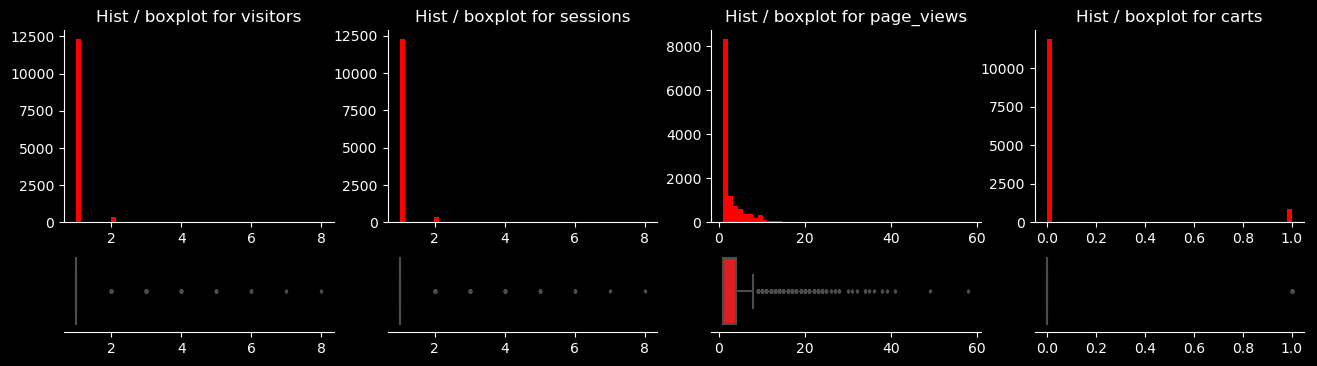

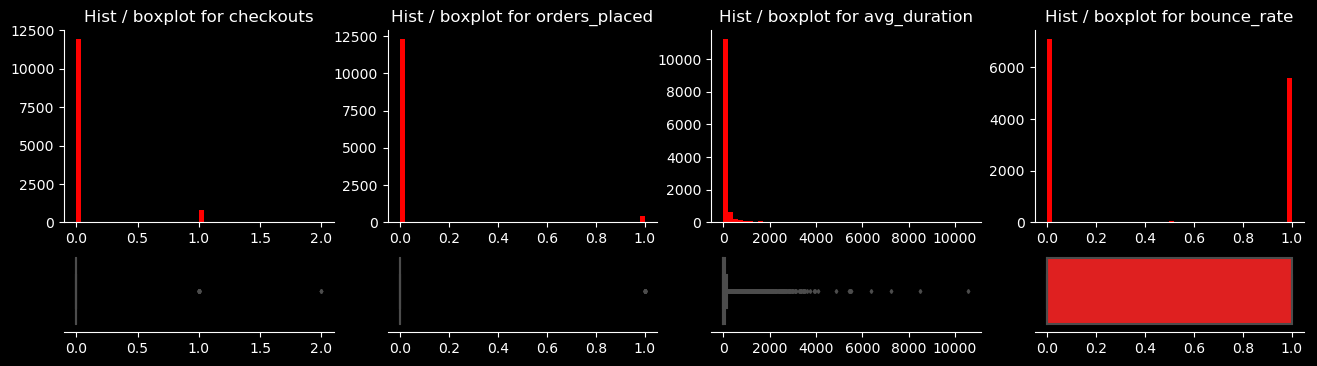

In [23]:
cols = [["visitors", "sessions", "page_views", "carts"], ["checkouts", "orders_placed", "avg_duration", "bounce_rate"]]

for i in cols:
    fig, axes = plt.subplots(
        2, 4, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(16, 4)
    )

    for (feat, plot_col) in zip(i, [0, 1, 2, 3]
    ):  
        axes[0, plot_col].hist(data[feat], bins=50, color='red')
        #axes[0, plot_col].set_yscale('log')
        #axes[0, plot_col].set_ylim(1, 100000)
        axes[0, plot_col].set_title("Hist / boxplot for {}".format(feat))
        sns.despine(ax=axes[0, plot_col])
        sns.boxplot(data[feat], ax=axes[1, plot_col], fliersize=2, color='red')
        axes[1, plot_col].set(yticks=[])
        sns.despine(ax=axes[1, plot_col], left=True)

    for ax in axes.flatten():
        ax.set_xlabel("")

    plt.show()

Data is heaviliy left-skewed. We need to compare the distribution of these values on a log scale.

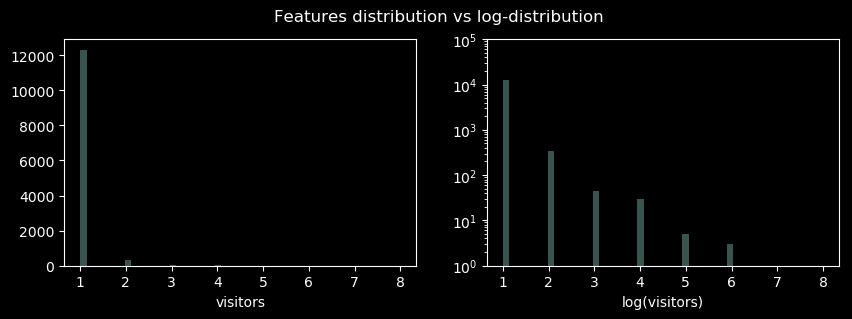

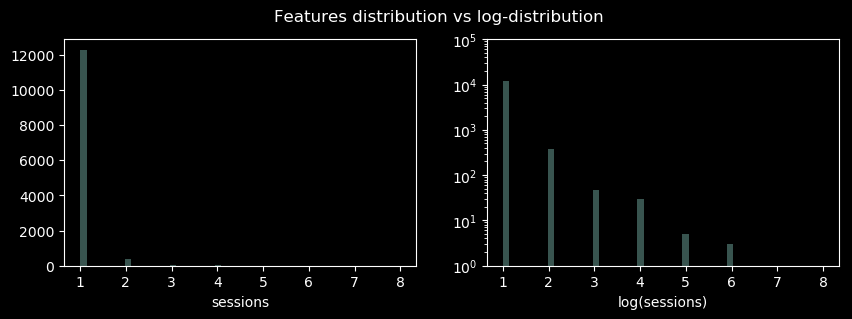

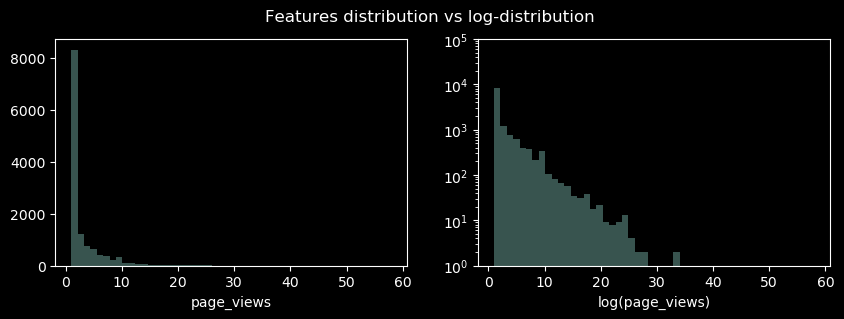

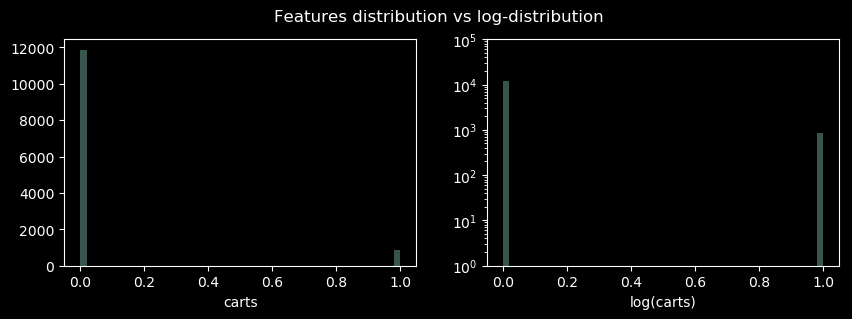

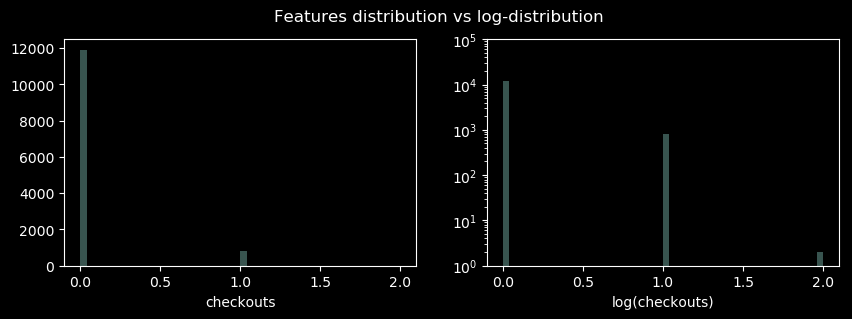

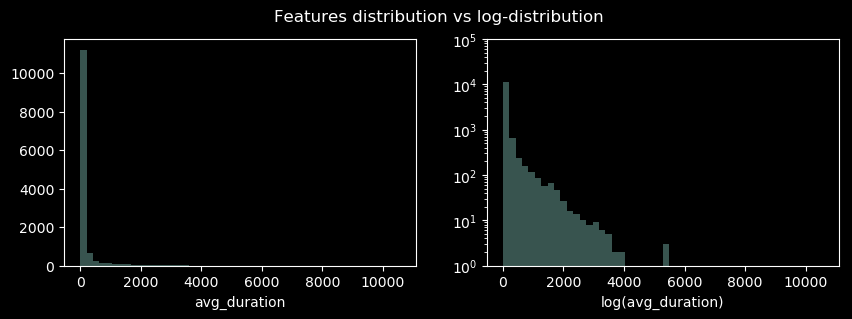

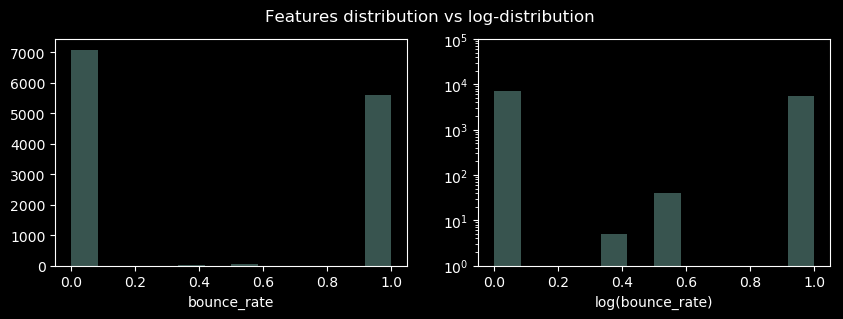

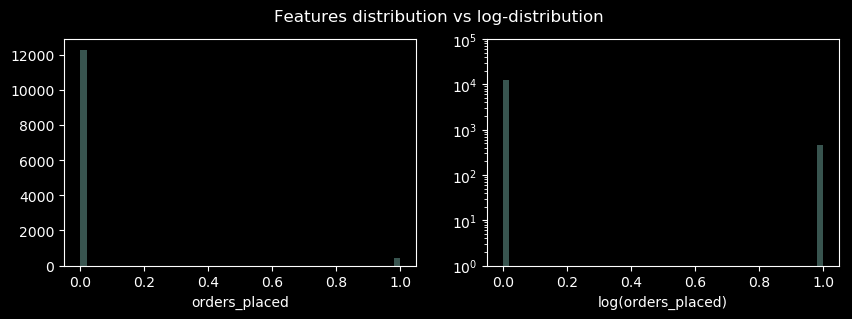

In [24]:
# Check Features distribution vs log-distribution

for i in data.select_dtypes(include=np.number).columns:

    fig, ax = plt.subplots(1,2,figsize=(10, 3))
    fig.suptitle('Features distribution vs log-distribution')

    sns.distplot(data[i], kde=False, ax=ax[0])
    ax[0].set_xlabel(i)
    #ax[0].set_yscale('log')
    #ax[0].set_ylim([1, 100000])

    sns.distplot(data[i], kde=False, ax=ax[1])
    ax[1].set_xlabel('log({})'.format(i))
    ax[1].set_yscale('log')
    ax[1].set_ylim([1, 100000])

    plt.show()

There are very few visits/sessions with more than 1 visitor. Even `page_views` and `avg_duration` are concentrated on 1 value.   
Let's plot a Z-score and see which values fall within 3 standard deviations.

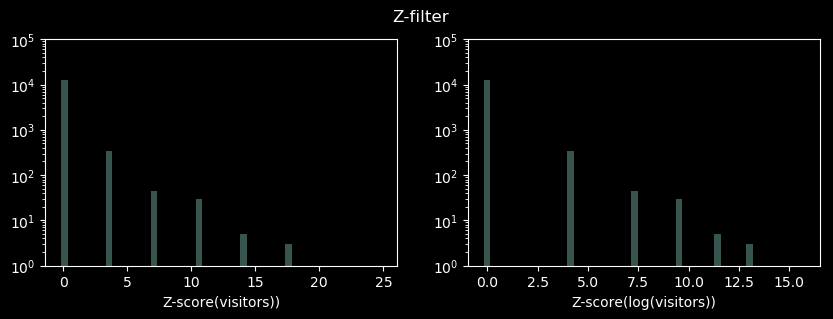

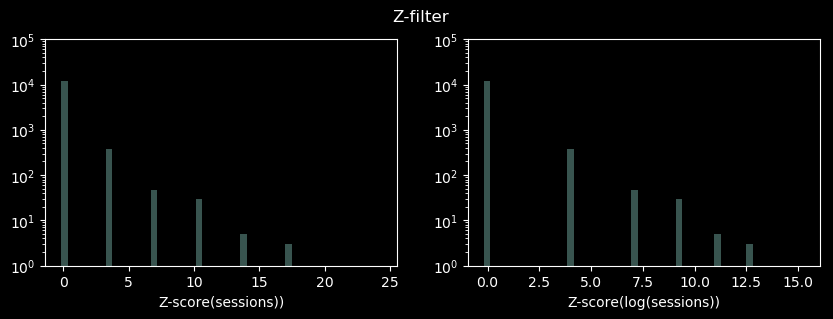

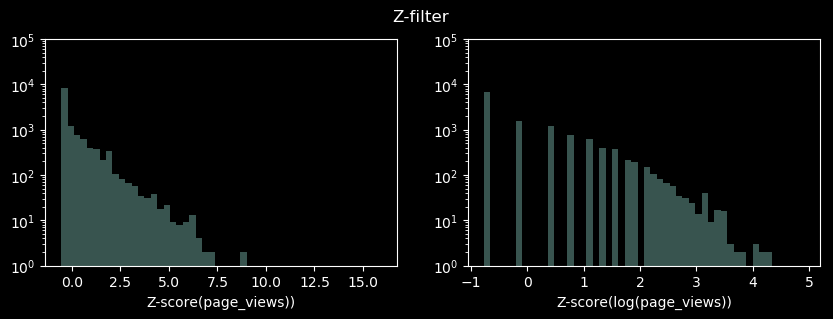

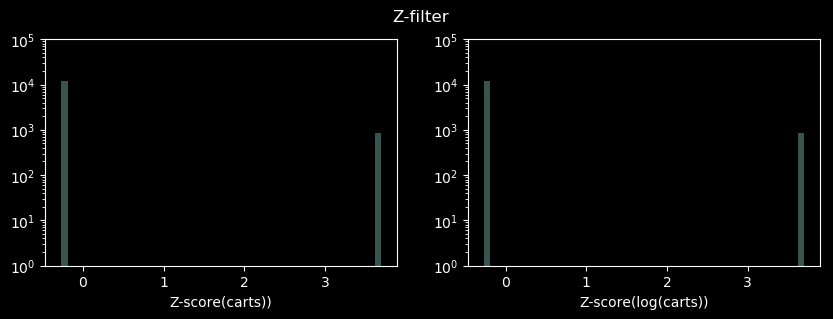

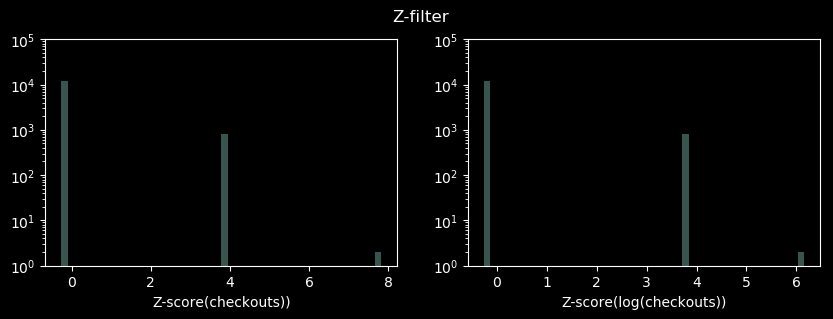

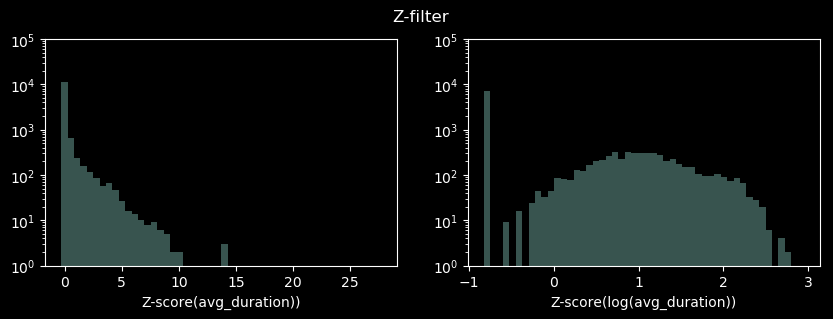

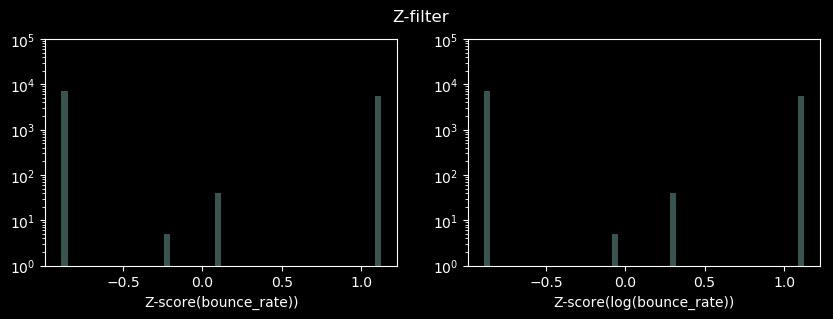

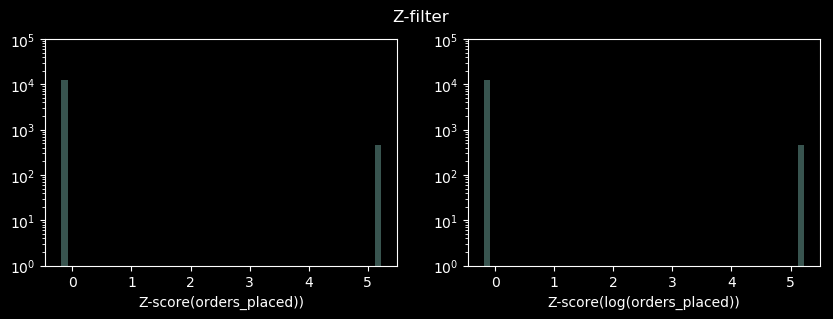

In [25]:
from scipy.stats import zscore

# Check Z-score

for i in data.select_dtypes(include=np.number).columns:
    x = data[i].dropna()

    fig, ax = plt.subplots(1,2,figsize=(10, 3))
    fig.suptitle('Z-filter')

    sns.distplot(zscore(x), kde=False, ax=ax[0], bins=50,  axlabel='Z-score({}))'.format(i))
    ax[0].set_yscale("log")
    ax[0].set_ylim(1, 100000)

    sns.distplot(zscore(np.log1p(x)), kde=False, ax=ax[1], bins=50, axlabel='Z-score(log({}))'.format(i))
    ax[1].set_yscale("log")
    ax[1].set_ylim(1, 100000)

    plt.show()    

Since the data is imbalanced and left-skewd. Very few values fall into the 3 std.  

Since Z-score filter do not work well with skewed or binary data, we will have to do a manual filter with the binary data. For the other features, we will do a log-transformed the data and then apply a z-filter:

- **['bounce_rate']** can take only `{0, 1}` (stayed on site or left)
- **['carts']** can take only `{0, 1}`
- **['checkouts']** can take only `{0, 1}`
- **['orders_placed']** can take only `{0, 1}`
- **['visitors']** Remove `users > 1` as they are outliers
- **['sessions']** Remove `sessions > 1`, as they are outliers
- **['page_views']** log-transformation to counter the skewness of the distribution then z-filter
- **['avg_duration']** log-transformation to counter the skewness of the distribution then z-filter

In [26]:
# Manual filters
def manual_filter(df):
    orders_before = df['orders_placed'].sum()
    print('Previous shape: ', df.shape)

    a = df['visitors'] > 1
    b = df['carts'] > 1
    c = df['checkouts'] > 1
    d = (df['bounce_rate'] < 1) & (0 < df['bounce_rate'])
    e = df['orders_placed'] > 1
    f = df['sessions'] > 1

    idx = a | b | c | d | e | f
    print('Filtered: ', idx.sum())

    df = df.loc[~idx]
    orders_after = df['orders_placed'].sum()
    print('{:.1%} of data / {:.1%} of orders removed'.format((idx.sum() / len(data)), (orders_before - orders_after) / orders_before))
    print('New shape: ', df.shape)

    return df

In [27]:
# Filter selected features
data = manual_filter(data)

Previous shape:  (12725, 20)
Filtered:  467
3.7% of data / 1.6% of orders removed
New shape:  (12258, 20)


We lose <4% of the data and <2% of orders. The manual filter worked fine.

In [28]:
# Log Features
to_log = ['page_views', 'avg_duration']

def log_df(df):
    for c in to_log:
        df[c] = np.log1p(df[c])
    return df

# Log selected features
data = log_df(data)

We can now apply a Z-filter on the non-binary features.  

In [29]:
from scipy.stats import zscore

# Filter outliers
to_filter = ['page_views', 'avg_duration']

print('Z-filter:\n')

orders_before = data['orders_placed'].sum()
outliers_all = pd.DataFrame([])

for c in to_filter:
    zfilter_df = np.abs(zscore(data[c])) > 3.5
    
    print(c, ': ', zfilter_df.sum())
    outliers = data.iloc[zfilter_df]
    outliers_all = outliers_all.append(outliers)
    
print('\nAll outliers: {}/{} / {:.1%} of data\n'.format(outliers_all.shape[0], len(data), (outliers_all.shape[0] / len(data))))

data.drop(outliers_all.index, axis=0, inplace=True)
orders_after = data['orders_placed'].sum()

print('{:.1%} of data / {:.1%} of orders removed'.format((outliers_all.shape[0] / len(data)), (orders_before - orders_after) / orders_before))
print('New shape of dataframe: ', data.shape)

Z-filter:

page_views :  18
avg_duration :  0

All outliers: 18/12258 / 0.1% of data

0.1% of data / 1.8% of orders removed
New shape of dataframe:  (12240, 20)


We had to use a z-filter of 3.5 instead of 3 since the latter was removing 10% of the orders. Due to the imbalanced data, it's better to try to keep them as much as possible. 

##### After check

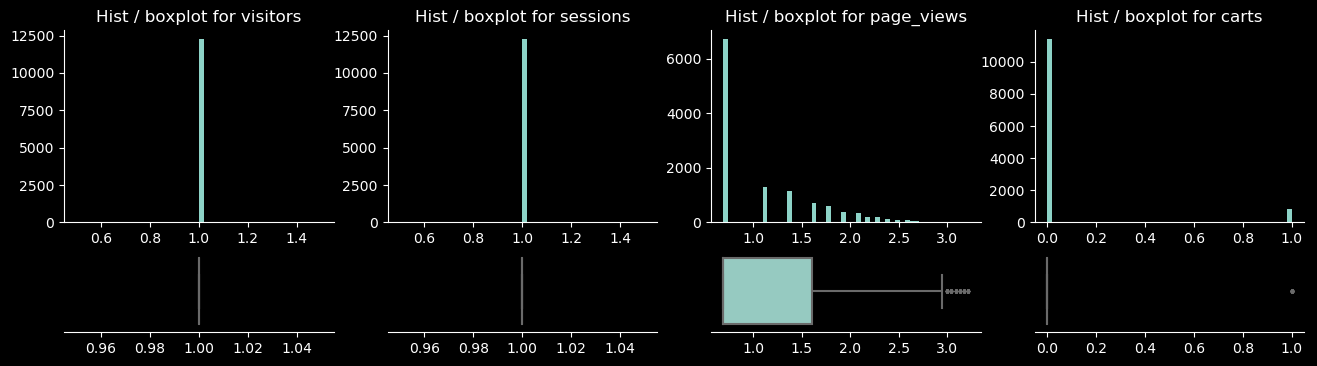

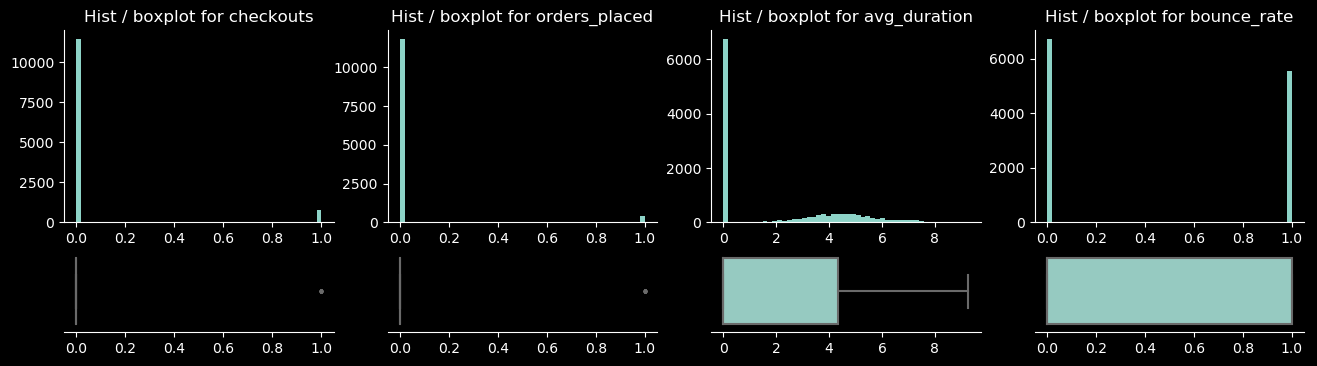

In [30]:
cols = [["visitors", "sessions", "page_views", "carts"], ["checkouts", "orders_placed", "avg_duration", "bounce_rate"]]

for i in cols:
    fig, axes = plt.subplots(
        2, 4, gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(16, 4)
    )

    for (feat, plot_col) in zip(i, [0, 1, 2, 3]
    ):  
        axes[0, plot_col].hist(data[feat], bins=50)
        #axes[0, plot_col].set_yscale('log')
        #axes[0, plot_col].set_ylim(1, 100000)
        axes[0, plot_col].set_title("Hist / boxplot for {}".format(feat))
        sns.despine(ax=axes[0, plot_col])
        sns.boxplot(data[feat], ax=axes[1, plot_col], fliersize=2)
        axes[1, plot_col].set(yticks=[])
        sns.despine(ax=axes[1, plot_col], left=True)

    for ax in axes.flatten():
        ax.set_xlabel("")

    plt.show()

The data looks cleaner. 
- `page_views` and `avg_duration` are in log(sec) and log(#pages).
- `visitors` and `sessions` becomes useless (only values of '1'. We can delete them (we will keep `visitors` just for the EDA to simplify queries).

In [31]:
data.drop(columns='sessions', inplace=True)

### Outliers in Categorical Data

There are too many levels in each categorical feature. Therefore, we will compute a K-Best with chi2 on each feature and select the best levels.

In [32]:
from sklearn.feature_selection import SelectKBest, chi2

# Define function
def select_kbest(index='None'):
    
    values = data[[index, 'orders_placed']]
    encoded_values = pd.get_dummies(values, columns=[index], prefix='', prefix_sep='')

    # Shift order
    cols = list(encoded_values.columns)
    cols = cols[1:] + [cols[0]]
    encoded_values = encoded_values[cols]

    # Select levels with at least 30 samples
    s = 30
    mask = encoded_values.sum() > s
    encoded_values = encoded_values[encoded_values.columns[mask]]

    # Number of feats
    number_feats = len(encoded_values.columns) - 1

    # Create X/y data
    X = encoded_values.drop(['orders_placed'], axis=1).values
    y = encoded_values['orders_placed'].values

    # Create object
    skb = SelectKBest(chi2, k='all')

    # Fit SKB
    X_new = skb.fit_transform(X,y)

    # Get the indices sorted by most important to least important
    indices = np.argsort(skb.scores_)[::-1]

    # Feature names
    features = []
    for i in range(number_feats):
        features.append(encoded_values.columns[indices[i]])

    # plot
    fig = plt.figure()
    plt.bar(features, skb.scores_[indices[range(number_feats)]], align='center')
    plt.xticks(rotation=90)
    plt.title('K-Best scores per {}'.format(index))
    plt.grid(color='gray', alpha=.2, axis='y')
    plt.show()
    
    k_feat = np.argsort(skb.pvalues_)
    k_feat = encoded_values.columns[k_feat]
    
    return k_feat

# https://stackoverflow.com/questions/40245277/visualize-feature-selection-in-descending-order-with-selectkbest

In [33]:
# Stacked graph
def draw_graph(index=None, n=10):
    temp = data.pivot_table(values='orders_placed', index=index, aggfunc={'sum', 'count'})
    temp['order_1'] = temp['sum'] / temp['count']
    temp['order_0'] = (temp['count'] - temp['sum']) / temp['count']
    temp.sort_values('order_1', ascending=False, inplace=True)
    temp = temp.head(n)

    # Graphs
    fig, ax = plt.subplots(1,1)

    # First graph
    ax.set_title('Orders per {}'.format(index))
    ax.set_ylim(0, 1.05)
    ax.grid(color='gray', alpha=.2, axis='y')
    ax.set_xlabel(index)
    ax.set_ylabel('counts (%)')
    ax.tick_params(labelrotation=90, axis='x')

    ax.bar(temp.index, temp.order_1, color='#2ecc71', bottom=temp.order_0, label='Order')
    ax.bar(temp.index, temp.order_0, color='#34495e', label='No order')
    ax.legend(loc=8)

    fig.tight_layout()
    plt.show()

#### Device

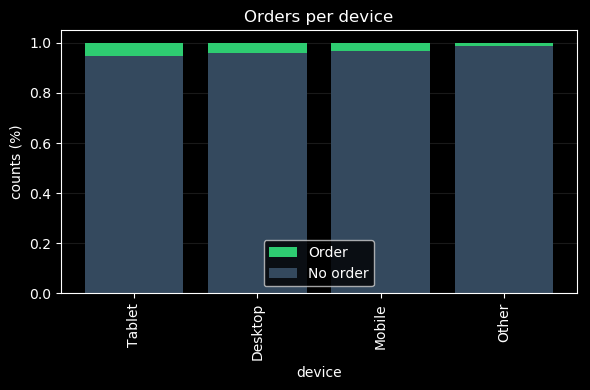

In [34]:
index = 'device'
draw_graph(index)

##### Check levels with kNN and chi2

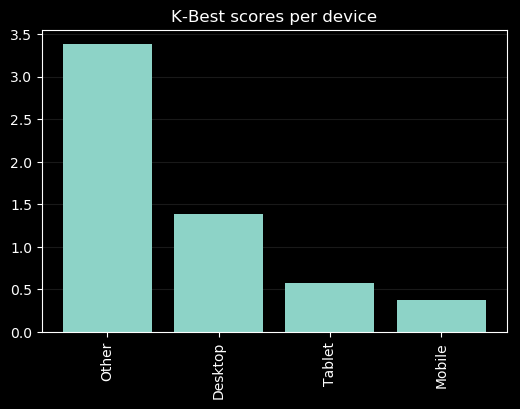

In [35]:
# Select best levels 
k_feat = select_kbest(index)

Surprisingly, `Other` is a better indicator than `Mobile`. We will keep the first 2 and merge `Tablet` and `Mobile`.

In [36]:
# Feats to keep
k = 2
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Mobile')

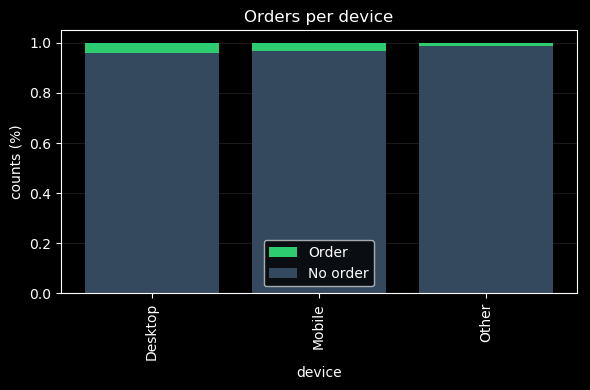

In [37]:
# After check
draw_graph(index)

#### Locations

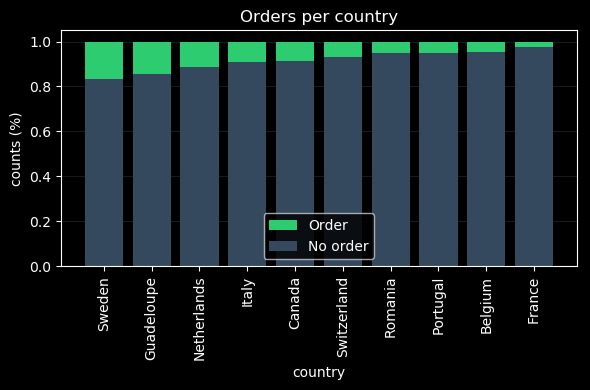

In [38]:
# Stacked graph
index = 'country'
draw_graph(index)

##### Check importance with Select K Best and chi2

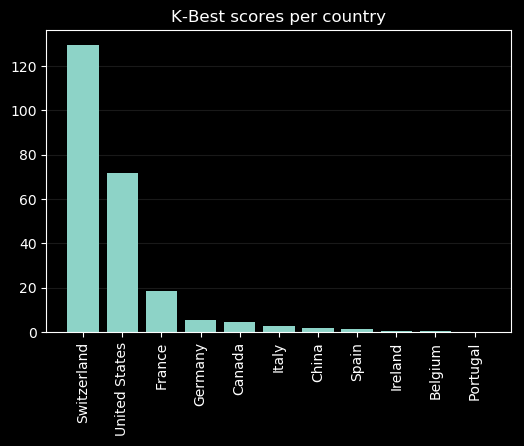

In [39]:
# Select best levels
k_feat = select_kbest(index)

`United States` is strong as there are no order from there, just visits. So a visit from the US is a very good indicator that no order will be made.  
Based on graph, we keep the first 3. CH and FR and the two biggest markets.

In [40]:
# Feats to keep
k = 3
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Other')

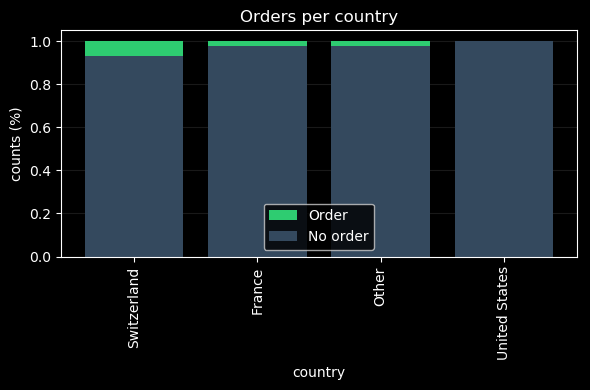

In [41]:
# After check
draw_graph(index)

#### Region

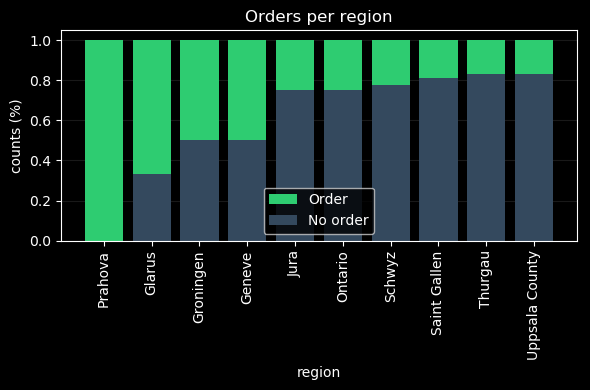

In [42]:
# Stacked graph
index = 'region'
draw_graph(index)

##### Check importance with Select K Best and chi2

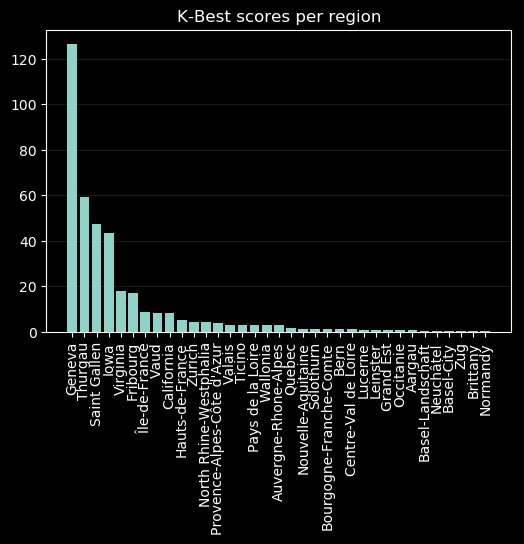

In [43]:
# Select best levels
k_feat = select_kbest(index)

Besed on graph, we keep the first 4.

In [44]:
# Feats to keep
k = 4
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Other')

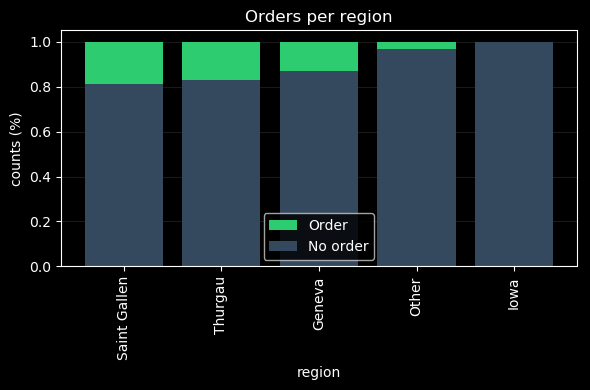

In [45]:
# After check
draw_graph(index)

#### City

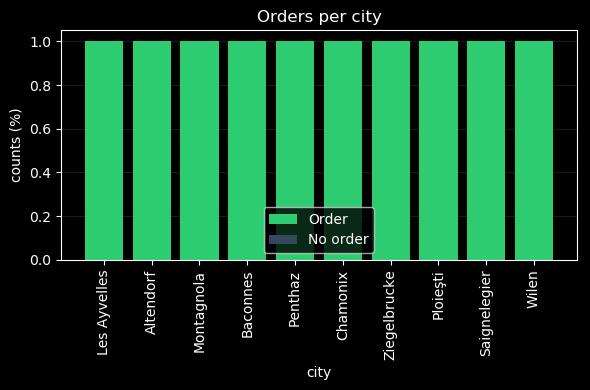

In [46]:
# Stacked orders per city
index = 'city'
draw_graph(index)

##### Check importance with Select K Best and chi2

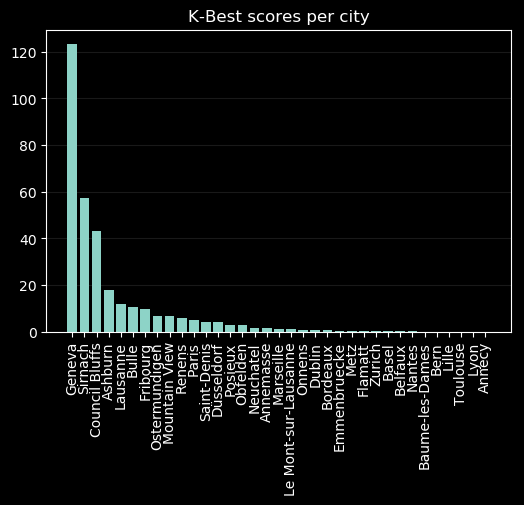

In [47]:
# Select best levels
k_feat = select_kbest(index)

We keep the first 4.

In [48]:
# Feats to keep
k = 4
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Other')

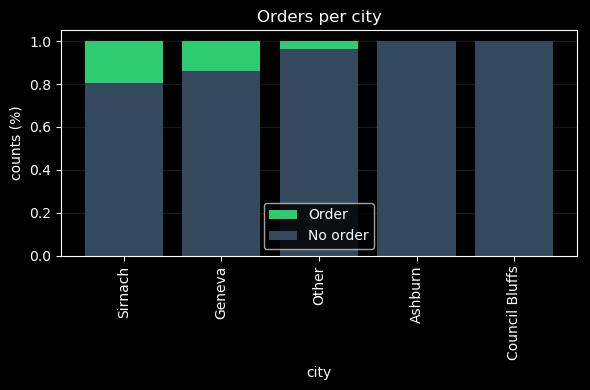

In [49]:
# After check
draw_graph(index)

#### Referrer Source

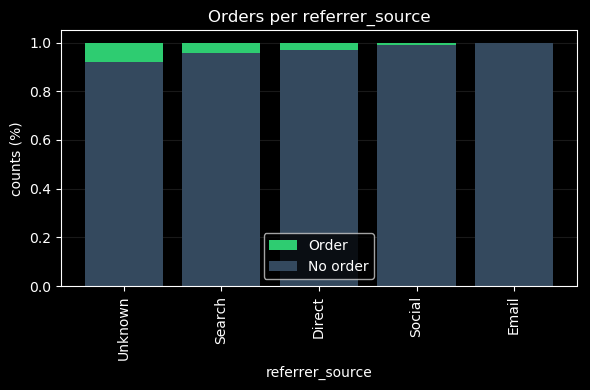

In [50]:
# Stacked graph
index = 'referrer_source'
draw_graph(index)

##### Check importance with Select K Best and chi2

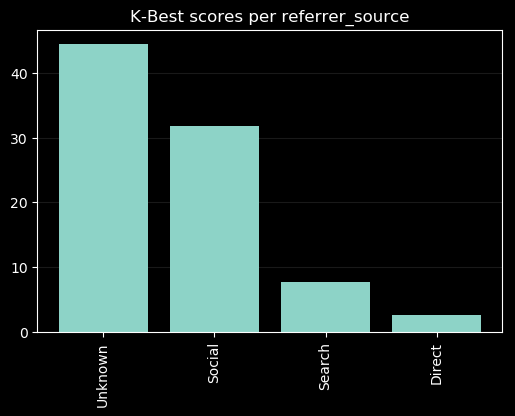

In [51]:
# Select best levels
k_feat = select_kbest(index)

We will keep the first 2 and merge the last 2.

In [52]:
# Feats to keep
k = 2
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Search')

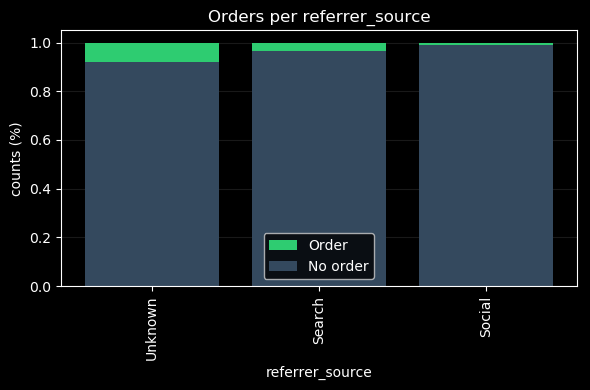

In [53]:
# After check
draw_graph(index)

#### Referrer host

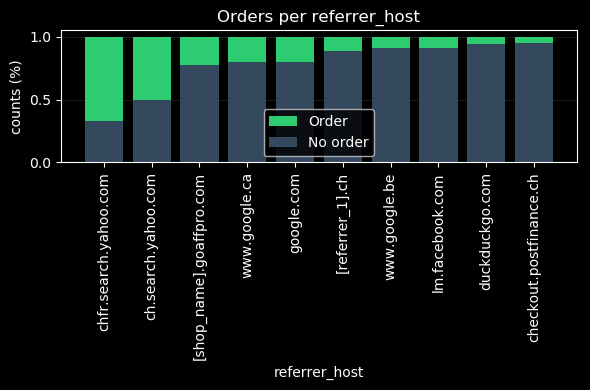

In [54]:
# Stacked graph
index = 'referrer_host'
draw_graph(index)

##### Check importance with Select K Best and chi2

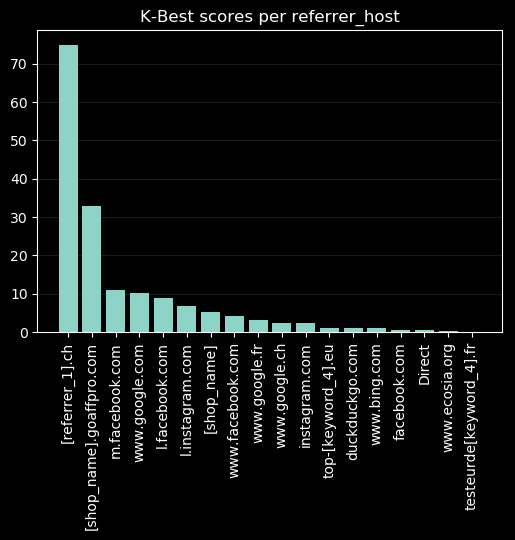

In [55]:
# Select best levels
k_feat = select_kbest(index)

We will keep the first 2.

In [56]:
# Feats to keep
k = 2
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Other')

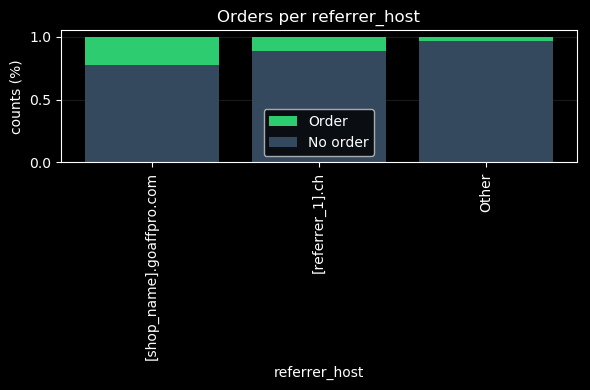

In [57]:
# After check
draw_graph(index)

##### Referrer_name & refetter_url
`Referrer_name` gives the same information as `referrer_source`. `referrer_url` gives the same info as `referrer_host`.  
We will delete both of them.

In [58]:
data = data.drop(columns=['referrer_name', 'referrer_url'])

#### Page_type

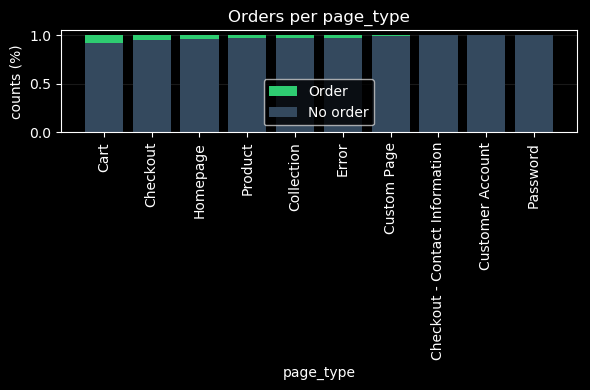

In [59]:
# Stacked graph
index = 'page_type'
draw_graph(index)

##### Check importance with Select K Best and chi2

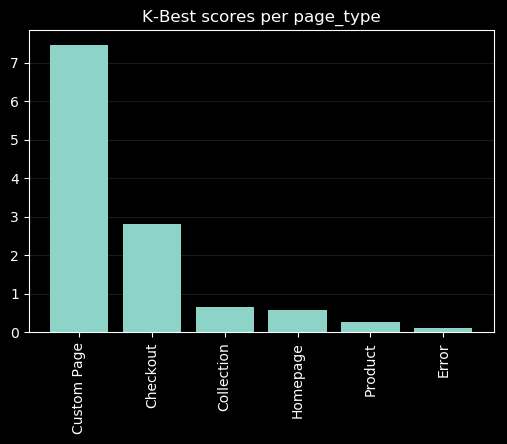

In [60]:
# Select best levels
k_feat = select_kbest(index)

Based on the graph, we will keep the first 2 and merge the others as `Site`.

In [61]:
# Feats to keep
k = 2
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Site')

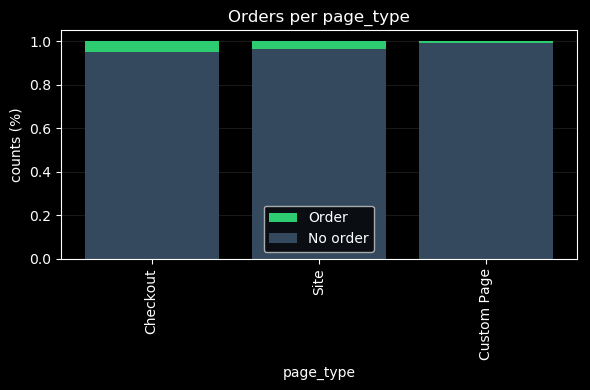

In [62]:
# After check
draw_graph(index)

#### Page_path

/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


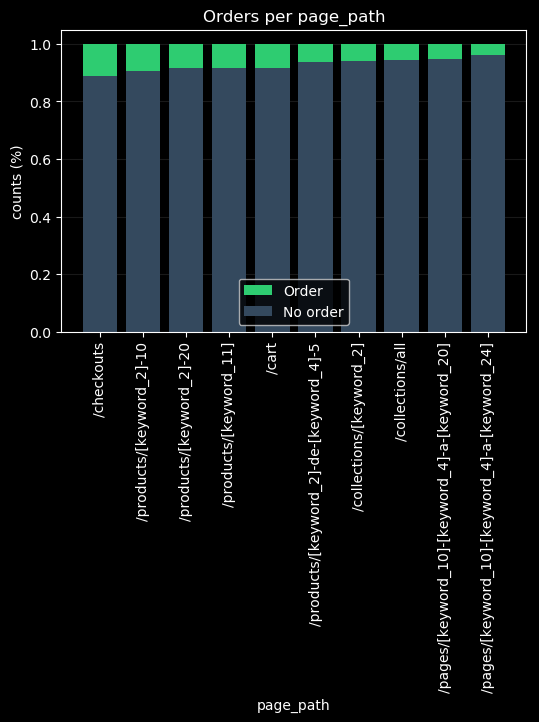

In [63]:
# Stacked graph
index = 'page_path'
draw_graph(index)

##### Check importance with Select K Best and chi2

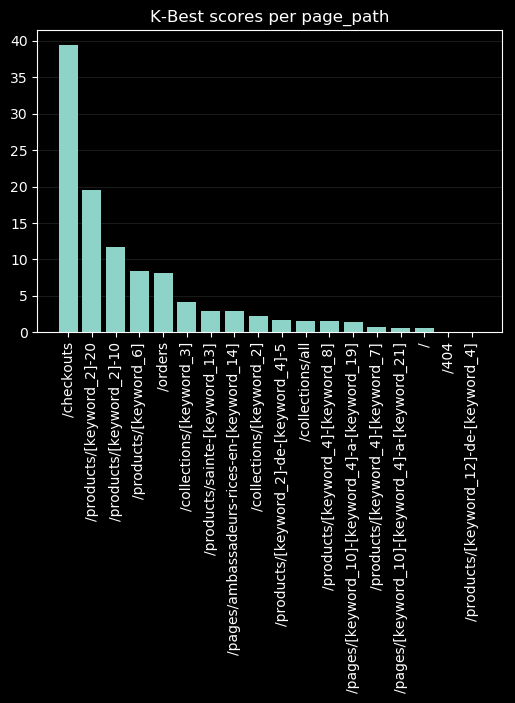

In [64]:
# Select best levels
k_feat = select_kbest(index)

Based on the graph, we will keep the first 3 and merge the others as `Site`.

In [65]:
# Feats to keep
k = 3
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Site')

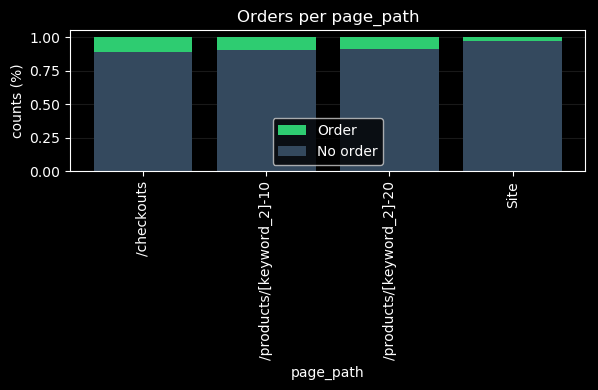

In [66]:
# After check
draw_graph(index)

##### Page URL

/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


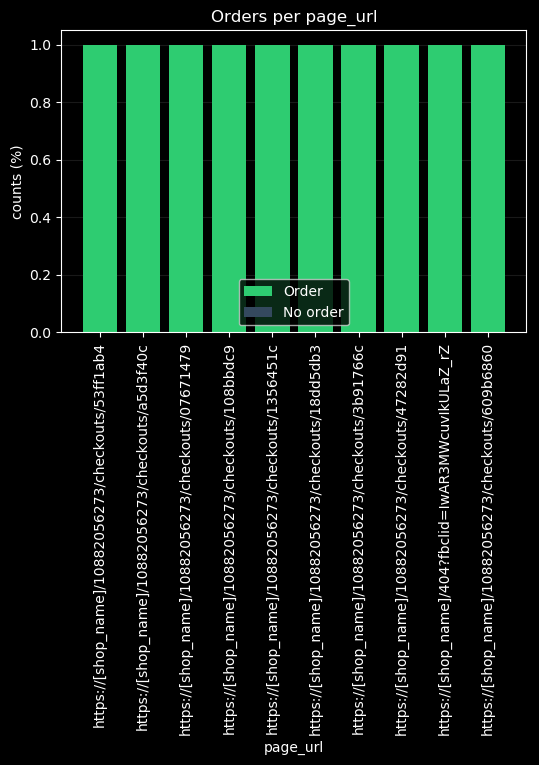

In [67]:
# Stacked graph
index = 'page_url'
draw_graph(index)

##### Check importance with Select K Best and chi2

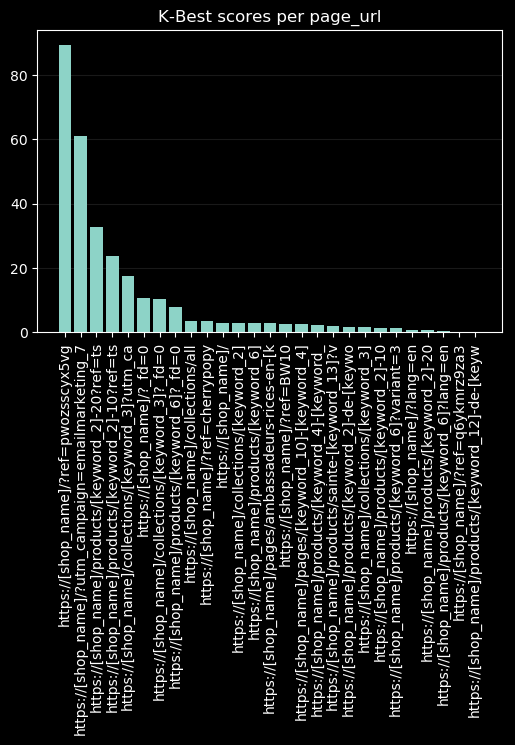

In [68]:
k_feat = select_kbest(index)

Based on the graph, we will keep the first 2 (they are marketing campains) and merge the others as `Other`.  

We take only the first 2 because positions 3-4 are the 2 product pages already captured by `page_path`.

In [69]:
# Feats to keep
k = 2
k_feat = k_feat[:k]

# Apply on data
data[index] = data[index].apply(lambda x: x if x in k_feat else 'Other')

/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


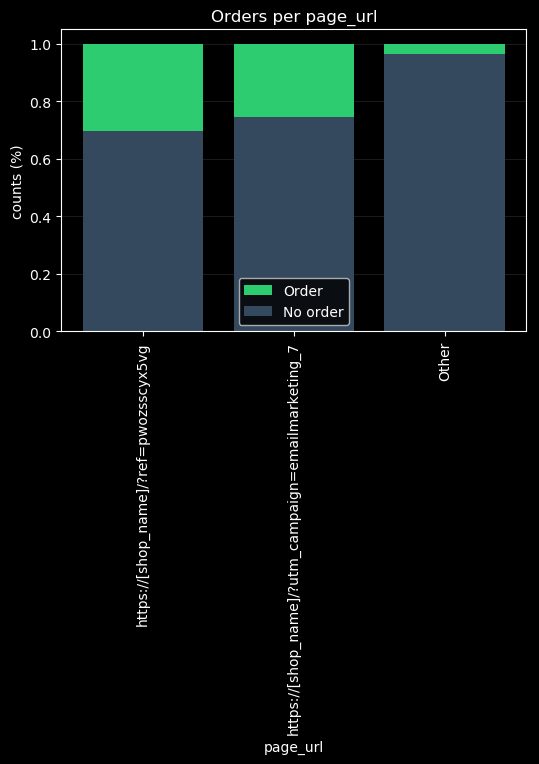

In [70]:
# After check
draw_graph(index)

### Feature enginerring

#### Time related features

/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


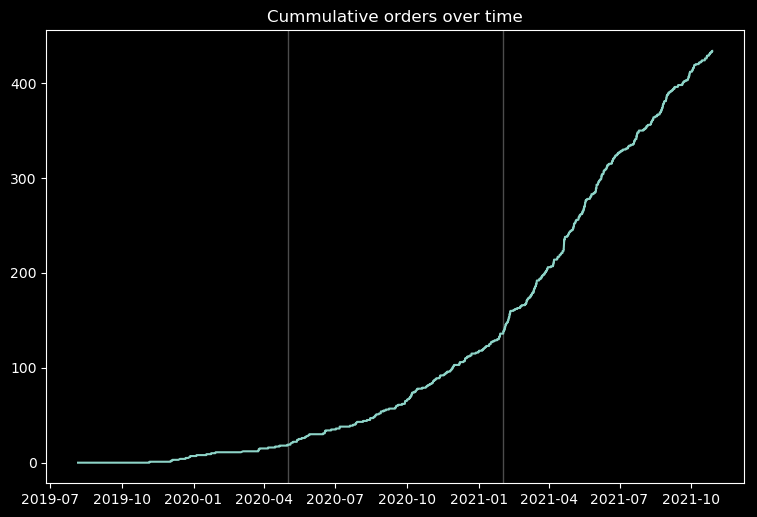

In [71]:
# Time trends
import datetime
kwargs={'alpha':0.3}
orders = data['orders_placed']
orders_cum = np.cumsum(orders)
plt.figure(figsize=(9, 6))
plt.title('Cummulative orders over time')
plt.axvline(datetime.datetime(2020, 5, 1), linewidth=1, linestyle='-', **kwargs)
plt.axvline(datetime.datetime(2021, 2, 1), linewidth=1, linestyle='-', **kwargs)
plt.plot(data.datetime, orders_cum);

We can see yearly trends here.  
We will some features that capture time trends.

In [72]:
# Create features with day of week and hour of day
data['hour_of_day'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year 
data['day_in_month'] = data['datetime'].dt.day
#data.drop(columns=['datetime'], inplace=True)

#### Shipping Cost

Let's add the shipping costs from the countries we selected above.

In [73]:
shipping = {'Switzerland': 2, 'France': 8, 'United States': 12, 'Other': 12}  
data['shipping'] = data['country'].map(shipping)

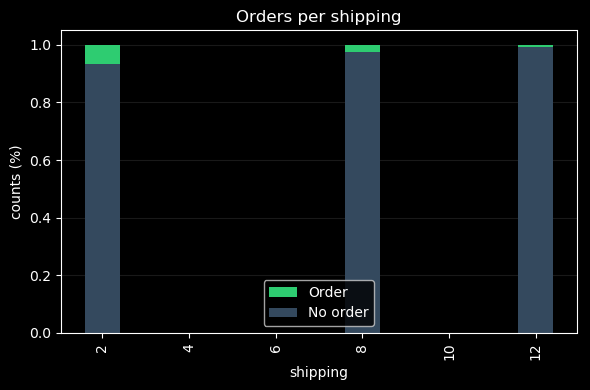

In [74]:
# Stacked orders
index='shipping'
draw_graph(index)

#### Legal accessibility

We can add also how much consumers are allowed to import in their country.

In [75]:
legal = {'Switzerland': 1, 'France': 0.2, 'United States': 1, 'Other': 0.2}  
data['legal'] = data['country'].map(legal)

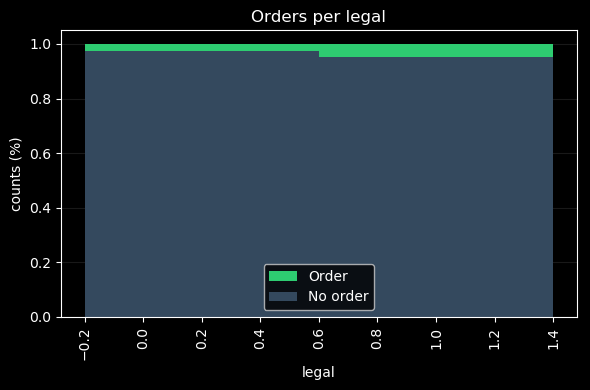

In [76]:
# Stacked orders
index='legal'
draw_graph(index)

## Visualize Data

Continuous
- datetime
- avg_duration
- page_views

Discrete
- bounce_rate
- carts
- checkouts
- orders_placed
- day
- hour_of_day
- month
- day_in_month
- year

Categorical
- referrer_source
- referrer_name
- referrer_host
- device
- page_type
- page_url
- page_path
- country
- region
- city

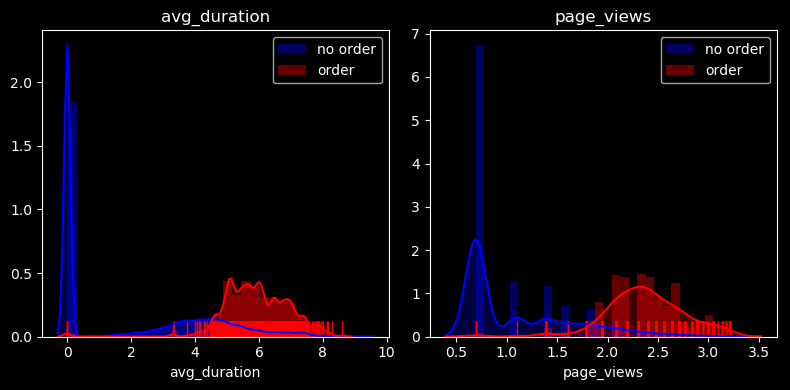

In [77]:
columns = ['avg_duration', 'page_views']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for c, ax in zip(columns, axes.ravel()):
    sns.distplot(data[data['orders_placed'] == 0][c], color='blue', bins=30, ax=ax, kde_kws={'bw':0.1, "shade": True}, label='no order')
    sns.distplot(data[data['orders_placed'] == 1][c], color='red', bins=30, ax=ax, kde_kws={'bw':0.1, "shade": True}, label='order', rug=True)
    ax.set_title(c)
    ax.legend(loc=1)

#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

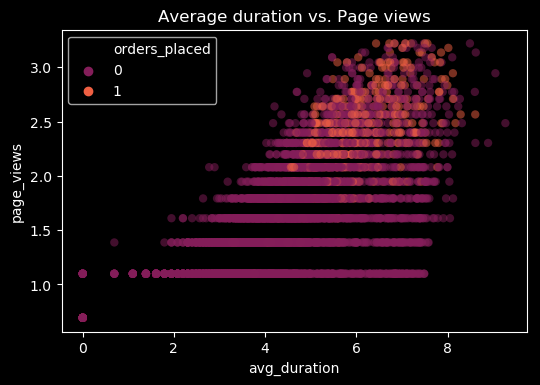

In [78]:
f, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x='avg_duration', y='page_views', hue='orders_placed', data=data,
                palette='rocket', edgecolor="none", alpha=0.5)
plt.title('Average duration vs. Page views')
plt.legend()
plt.show()

People who order visit more pages and spend more time on the site.

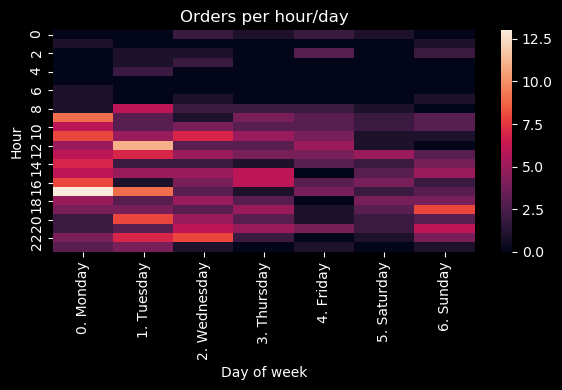

In [79]:
# Heatmap
df3 = data.groupby('datetime').sum()
df3['hourofday'] = df3.index.hour
df3['day'] = df3.index.dayofweek
df3['day'].replace({0: '0. Monday', 1: '1. Tuesday', 2: '2. Wednesday', 3: '3. Thursday', 4: '4. Friday', 5: '5. Saturday',
                    6: '6. Sunday'}, inplace=True)

# Create tables
df4 = df3.pivot_table(index='hourofday', columns='day', values='orders_placed', aggfunc='sum')

# Graph
fig, ax = plt.subplots(1,1)
ax.set_title('Orders per hour/day')
sns.heatmap(df4, cmap='rocket', ax=ax)
ax.set(ylabel='Hour', xlabel='Day of week')

fig.tight_layout()
plt.show()

Orders occur mainly at the beginning of the week in the afternoon.

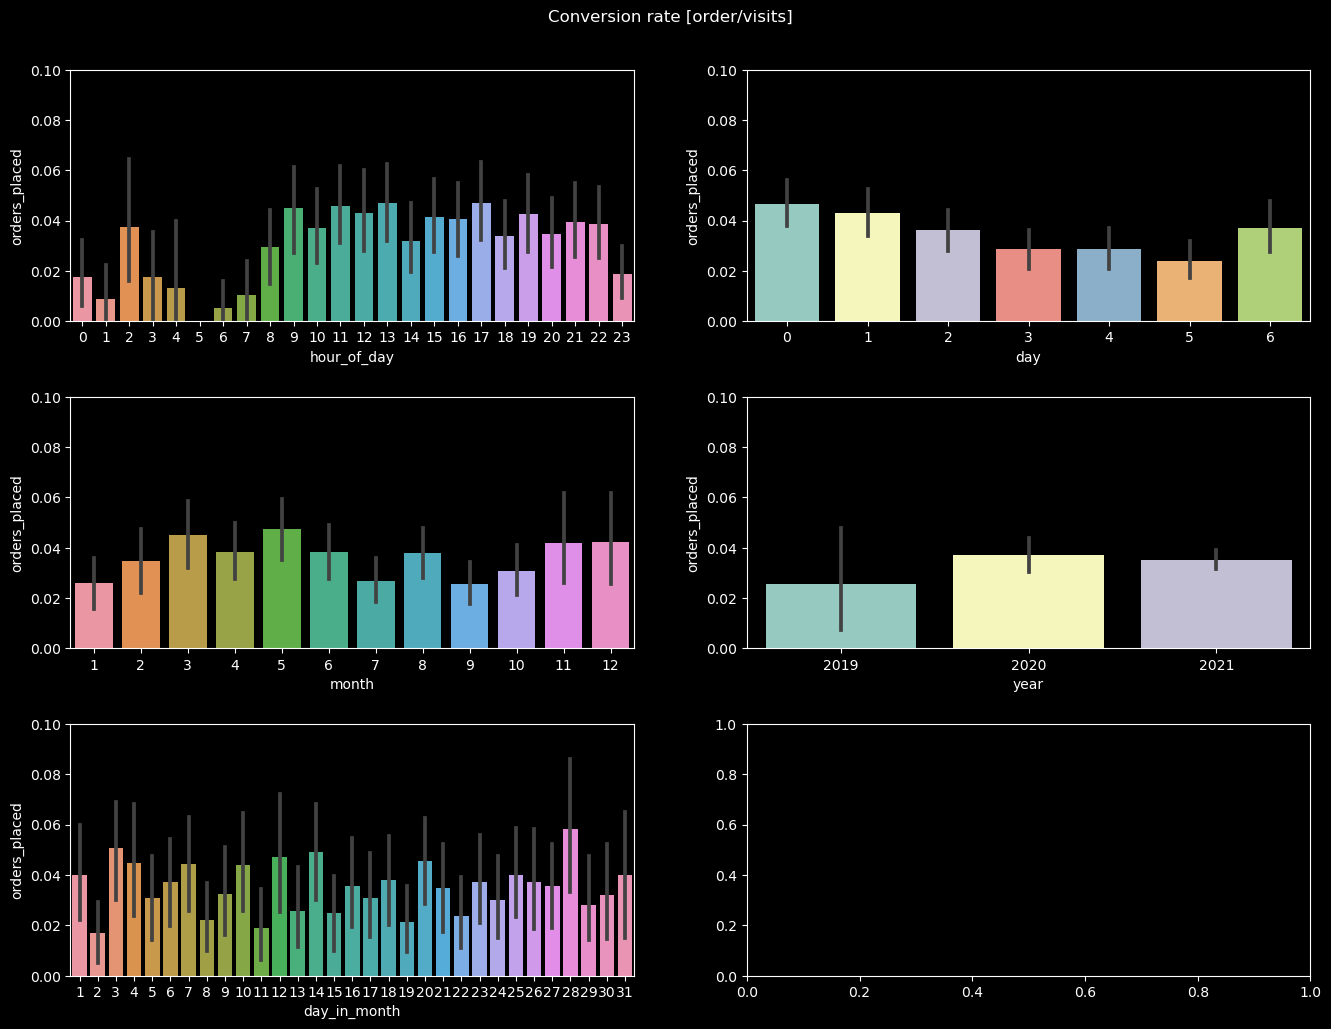

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
fig.suptitle('Conversion rate [order/visits]', y=.93)
fig.subplots_adjust(hspace=.3)

for c, ax in zip(['hour_of_day', 'day', 'month', 'year', 'day_in_month'], axes.ravel()):
    sns.catplot(x=c, y="orders_placed", data=data, kind='bar', ax=ax);
    #ax.set_title(c)
    ax.set(ylim=(0,.1))

plt.tight_layout()
plt.close(2), plt.close(3), plt.close(4), plt.close(5), plt.close(6)

plt.show()

- Sunday-Tuesday (6, 0, 1) is the period of the week with the highest number of orders.
- November/December are good months. The beginning of the year sees a drop in sales.
- 2020 saw a bump in conversion compared to 2019.
- No visual trend in `day_in_month`.

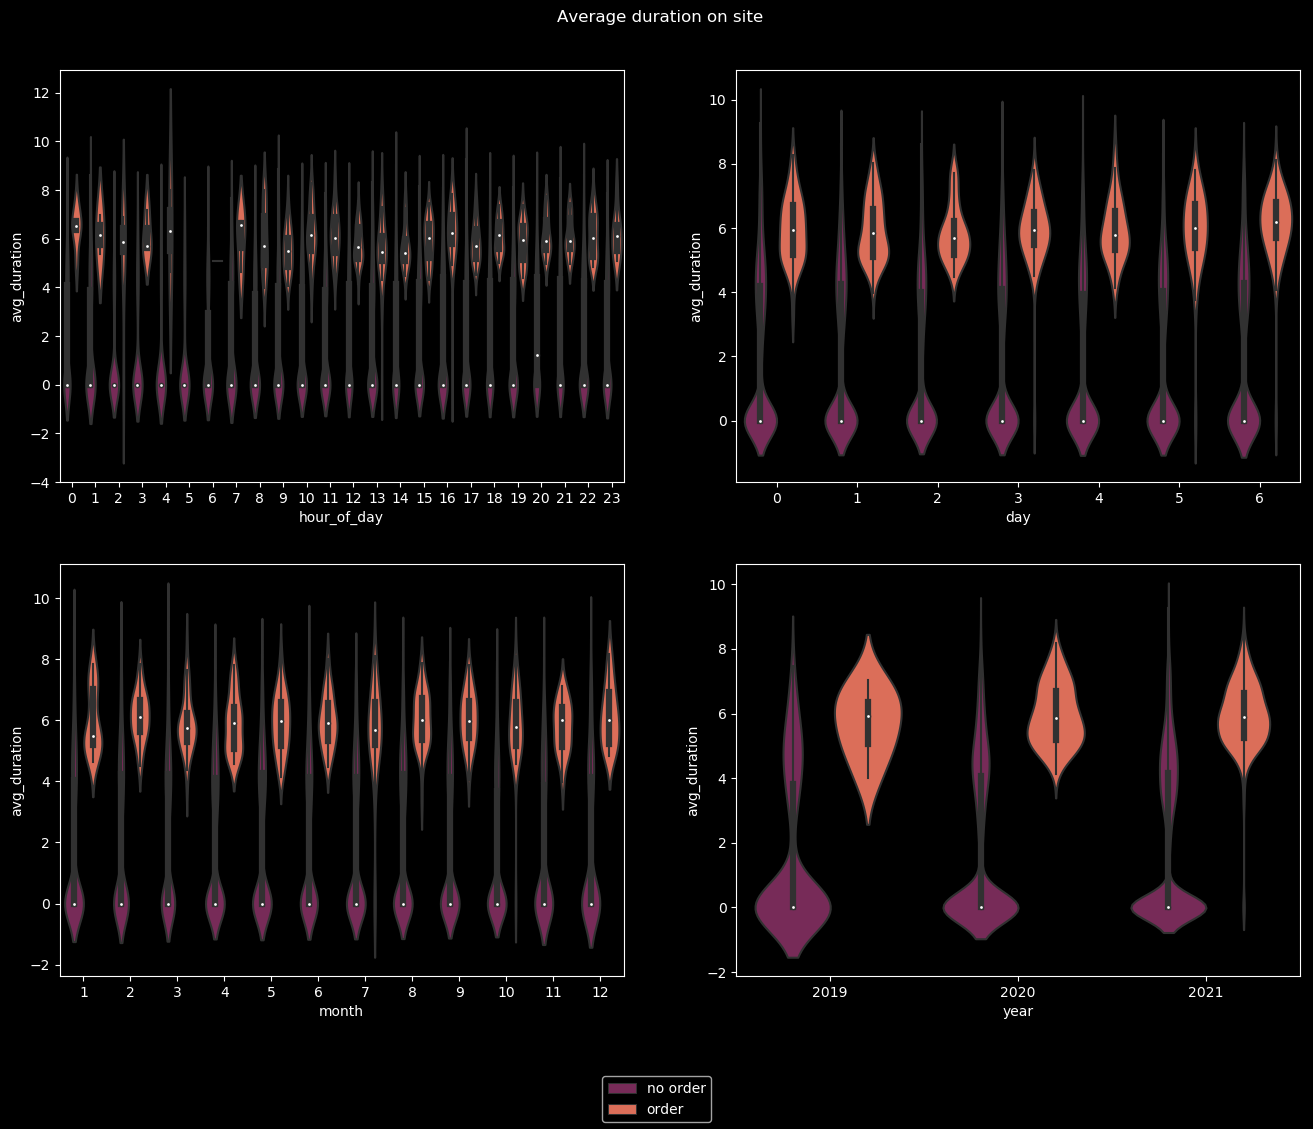

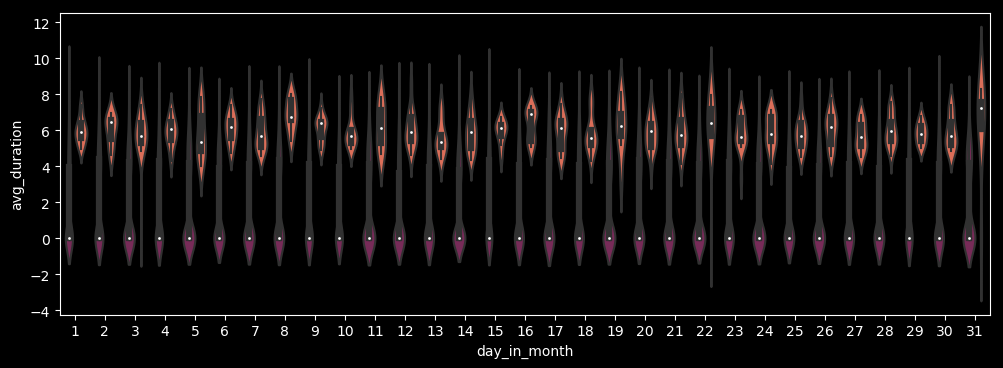

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Average duration on site', y=.93)

for c, ax in zip(['hour_of_day', 'day', 'month', 'year'], axes.ravel()):
    sns.catplot(x=c, y='avg_duration', hue="orders_placed", data=data, kind='violin', ax=ax, palette='rocket');
    #ax.set_title(c)
    ax.get_legend().remove()
    #ax.set(ylim=(0,.08))

    
line, Label = ax.get_legend_handles_labels()    

fig.legend(line, ['no order', 'order'], loc=8)
#plt.tight_layout()

plt.close(2), plt.close(3), plt.close(4), plt.close(5),
plt.show()

f, ax = plt.subplots(figsize=(12, 4))
sns.catplot(x='day_in_month', y='avg_duration', hue="orders_placed", data=data, ax=ax, kind='violin', palette='rocket');
ax.get_legend().remove()
plt.close(2)
plt.show()

Clear difference in behavior between people who order or not.

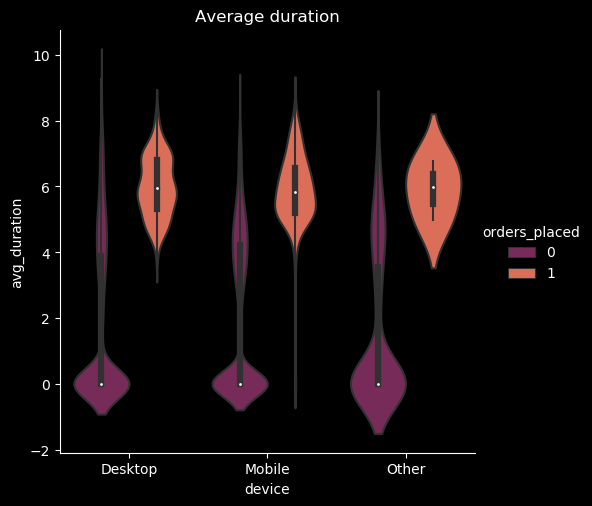

In [82]:
sns.catplot(x='device', y='avg_duration', hue="orders_placed", data=data, kind='violin', palette='rocket');
plt.title('Average duration');

Same thing with the device. Peole who order spend more time.

Ther more people spend time and visit pages, the more likely they will make an order.

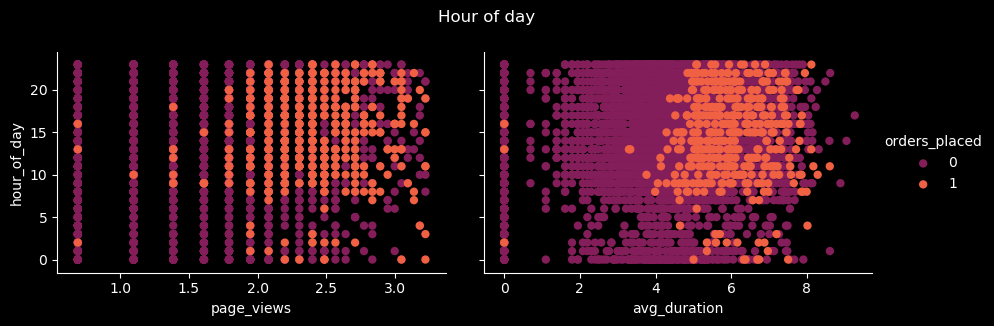

In [83]:
g = sns.pairplot(data=data, y_vars=['hour_of_day'], x_vars=['page_views', 'avg_duration'], hue='orders_placed',
            height=3, aspect=1.5, palette='rocket', plot_kws=dict(edgecolor="none"));
g.fig.suptitle("Hour of day", y=1.07)

plt.show()

#### Customer Funnel

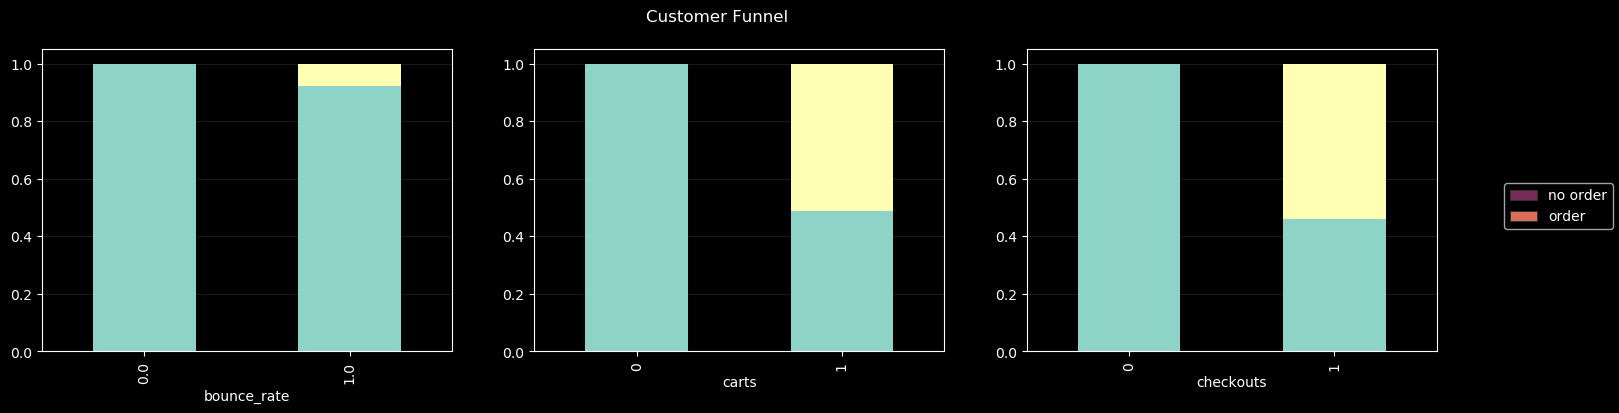

In [84]:
f, ax = plt.subplots(1,3, figsize=(18, 4))
f.suptitle('Customer Funnel')

pd.crosstab(data['bounce_rate'], data['orders_placed'], normalize="index").plot.bar(stacked=True, ax=ax[0])
ax[0].yaxis.grid(color='gray', alpha=.2)
ax[0].set_axisbelow(True)
ax[0].get_legend().remove()

pd.crosstab(data['carts'], data['orders_placed'], normalize="index").plot.bar(stacked=True, ax=ax[1])
ax[1].yaxis.grid(color='gray', alpha=.2)
ax[1].set_axisbelow(True)
ax[1].get_legend().remove()

pd.crosstab(data['checkouts'], data['orders_placed'], normalize="index").plot.bar(stacked=True, ax=ax[2])
ax[2].yaxis.grid(color='gray', alpha=.2)
ax[2].set_axisbelow(True)
ax[2].get_legend().remove()

f.legend(line, ['no order', 'order'], loc=7)
plt.show()

Filling the cart and going into checkout increase heavily the probability of making an order.

### Correlations
#### Spearman

In [85]:
# Try the spearman correlation
from scipy.stats import spearmanr

df = pd.DataFrame(columns=['Feature', 'orders_placed'])

for i in data.drop(columns='datetime').columns:
    # prepare data
    data1 = data['orders_placed']
    data2 = data[i]
    # calculate spearman's correlation
    coef, p = spearmanr(data1, data2)
    #print('Spearmans correlation coefficient: %.3f' % coef)

    df = df.append({'Feature': i, 'orders_placed': coef}, ignore_index=True)

df.set_index('Feature', inplace=True)
df.sort_values('orders_placed', ascending=False, inplace=True)

/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/catalina/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  retu

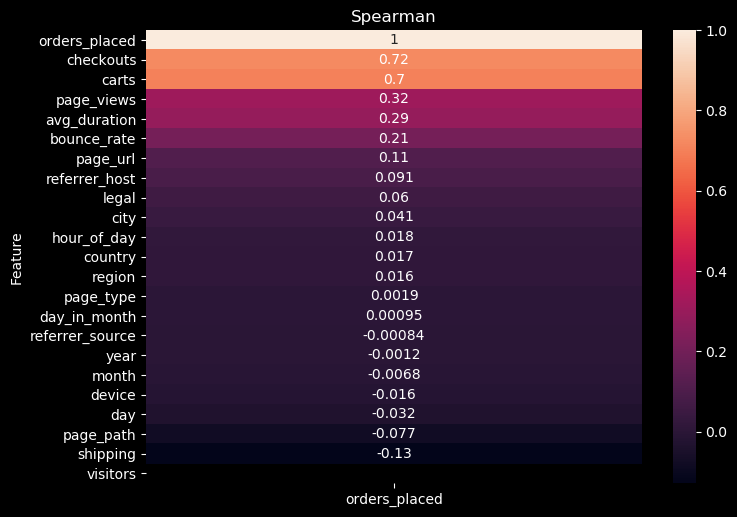

In [86]:
# heat Map
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Spearman')
ax = sns.heatmap(df, annot=True, cmap='rocket')

The Spearman orrelation works with the continuous features only but gives nevertheless some good indication.  

- `checkouts` has the highest correlation, it is the feature in the customer funnel that is the closest to making the order.
- `carts` follows just behind as expected.  
- `page_views` and `avg_duration` show some correlation even if their relationship is not exactly linear as seen in cell [238]


In [87]:
# Total number of different levels among categorical features
list_c = list(data.select_dtypes(exclude=np.number).columns)
list_c.remove('datetime')

g = 0
for i in list_c:
    g += len(data[i].unique())
print('Total number of different levels among categorical features: ', g)

Total number of different levels among categorical features:  33


### Finalize data preparation

In [88]:
data = data.drop(['visitors', 'datetime'], axis=1)

# save new dataframe
data.to_csv('data/data_processed.csv', index=False)

# Encode new dataframe
to_encode = ['referrer_source', 'referrer_host', 'device', 'page_type',
             'page_url', 'page_path', 'country', 'region', 'city']

encoded_df = pd.get_dummies(data, columns=to_encode, drop_first=False)
print('\nEncoded shape: ', encoded_df.shape)


Encoded shape:  (12240, 46)


## PCA
Let's compute a PCA and see how many components exlpain the variance of the model.

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = encoded_df.drop('orders_placed', axis=1).values
y = encoded_df.orders_placed.values

# scale first
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)    

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA
X_2d = pca.fit_transform(X_rescaled, y=None)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

### Scree Plot

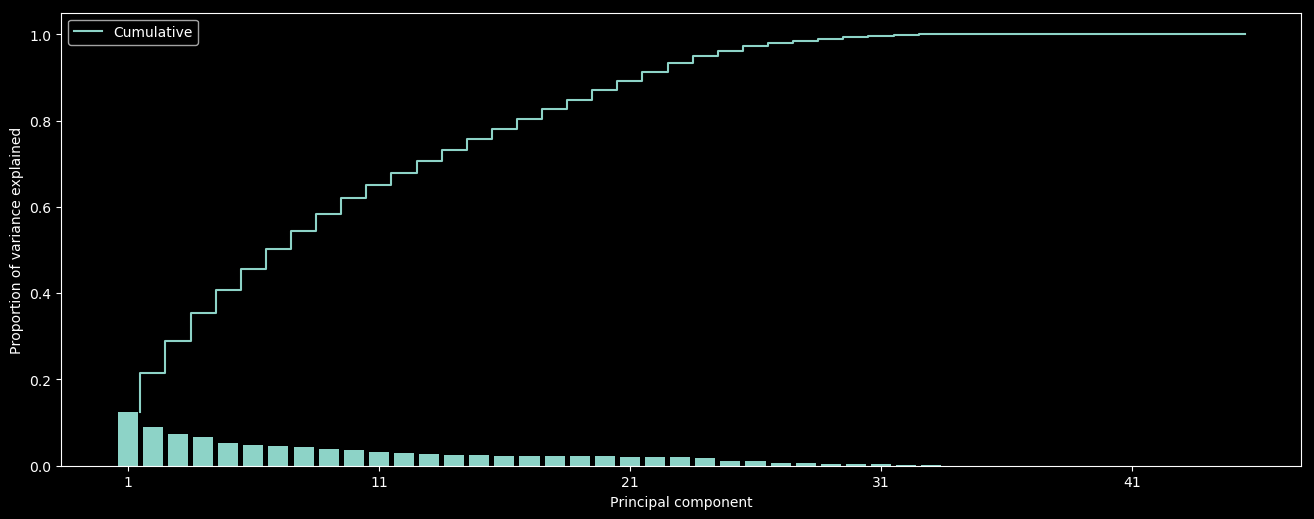

,Percentage,Number of PCA
0,0.1,1
1,0.2,2
2,0.3,4
3,0.4,5
4,0.5,7
5,0.6,10
6,0.7,13
7,0.8,17
8,0.9,22


In [90]:
import pandas as pd

# Bar plot
fig = plt.figure(figsize=(16,6))
xcor = np.arange(1, len(pve) + 1)
plt.bar(xcor, pve)
plt.xticks(xcor)

# Cumul sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5,
    pve_cumsum,
    label='Cumulative'
)

# labels
plt.xticks(np.arange(min(xcor), max(xcor), 10))
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()


## Table with number of PCA components for 10%-90% of variance
temp = pd.DataFrame(pve_cumsum, columns=['PCA'])
temp.index += 1

num_pca_comp = []

for i in range(1,10):
    # Take each step of 10%
    num_pca = temp[temp > i/10].idxmin(axis=0)
    
    num_pca_comp.append({
        'Percentage': i/10,
        'Number of PCA': num_pca
    })

# Save dataframe     
num_pca_comp = pd.DataFrame(num_pca_comp, columns=['Percentage', 'Number of PCA'])
num_pca_comp['Number of PCA'] = num_pca_comp['Number of PCA'].map(lambda x: str(x)[3:-13])
num_pca_comp

We need 17 components to reach the threshold of 80% of variance explained. That's a lot, there is no component that stands out. 

## 2d-plot

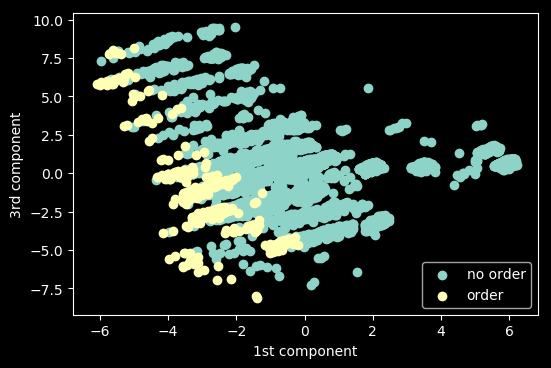

In [91]:
indices = {'no order': 0, 'order': 1}

for kind in [0,1]:
    idx = (y == kind)

    # Plot components
    plt.scatter(X_2d[idx, 0], X_2d[idx, 2], # Choose components
        label='type {}'.format(kind))

# Labels and legend
plt.legend(indices, loc=4)
plt.xlabel('1st component')
plt.ylabel('3rd component')
plt.show()

 ### Components
 Components 1-3 show a clear relationship. Component 2 is less clear (not shown here). Let's analyse the weights of each vector.

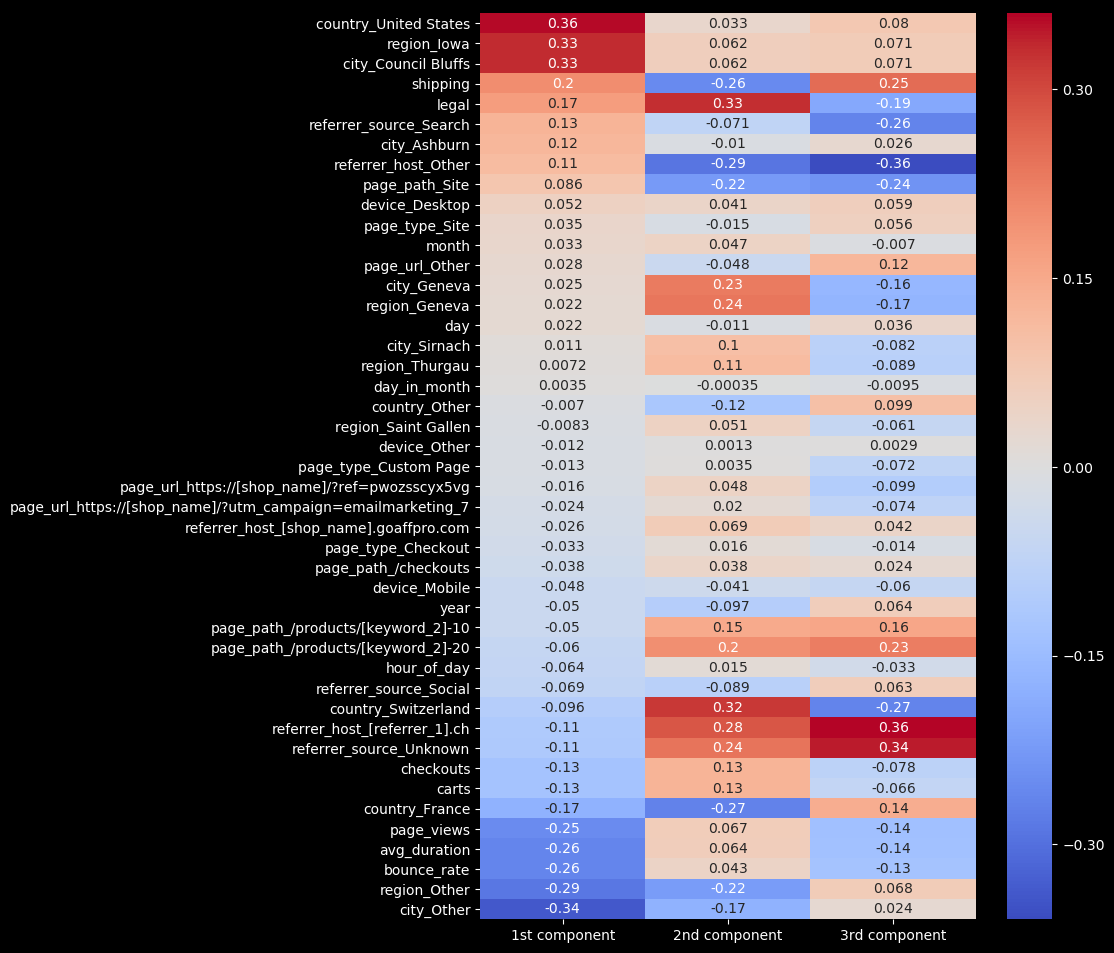

In [92]:
# DataFrame with variance and principal components
results_df = pd.DataFrame({
    #'variance': X_rescaled.var(axis=0),
    '1st component': pca.components_[0],
    '2nd component': pca.components_[1],
    '3rd component': pca.components_[2]
}).set_index(encoded_df.drop('orders_placed', axis=1).columns)

# Sort DataFrame by variance
results_df.sort_values('1st component', ascending=False, inplace=True)
#results_df

fig, ax = plt.subplots(1,1, figsize=(8,12))
sns.heatmap(results_df, annot=True, cmap='coolwarm', ax=ax)
plt.show()

1st component: site interaction vs USA  
2nd component: CH vs Other  
3rd component: Referrer  

- The 1st component has large coefficients for the United States (`coutry_United States` 0.36, `region_Iowa` 0.33) and large negatve coefficients with the whole customer funnel (`page_views`, `avg_duration`, `bounce_rate`) and other regions. This is the result of having no order from the United States. The component put it in the opposite direction.

- The second one is less contrasted but shows correlation with Switzerland, opposed to France (`country_Switzerland` 0.32, `city_Geneva` 0.23, `country_France` -0.27, `region_Other` -0.22)
- The 3rd one seems correlated with the referrers (`referrer_host_[referrer_1].ch` 0.36, `referrer_source_Unknown` 0.34, `referrer_host_Other` -0.36).

An interesting plot is therefore between Components 1 and 3. It shows the relationship between referrers and the customer journey on the site.

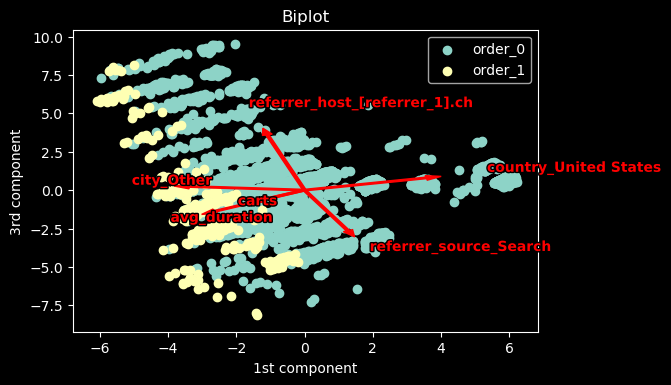

In [94]:
import matplotlib.patheffects as path_effects

# Plot each kind
for kind in [0, 1]:
    # Samples of this type
    idx = (y == kind)

    # Plot their components
    plt.scatter(
        X_2d[idx, 0], X_2d[idx, 2],
        label='order_{}'.format(kind)
    )

# Plot a few features using the weights in the loading vectors
for feature in ['city_Other', 'carts', 'avg_duration','country_United States',
               'referrer_host_[referrer_1].ch', 'referrer_source_Search']:
    # Get weights
    weight1 = results_df.loc[feature, '1st component']*10 # rescale them
    weight2 = results_df.loc[feature, '3rd component']*10 #

    # Plot arrows
    plt.arrow(
        0, 0, # Vector starts at (x,y)=(0,0)
        weight1, weight2, # ends at (x,y)=(weight1, weight2)
        color='red', width=0.1)

    # Add text
    text = plt.text(
        weight1 * 1.5, # x location (1.5 is arbitrary)
        weight2 * 1.5, # y location
        feature, # Feature name
        weight='bold', color='red')

    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('3rd component')
plt.title('Biplot')
plt.show()

We see how referrers influence orders. We can notice parrallel horizontal lines that represent each referrer. On these lines, orders are on the left, in the direction of `page_views`, `carts`, `avg_duration`. The United States is pointing on the other direction.

### (b) How does the EDA inform your project plan?

- Numerical features show clear differences with the target value.
    - `Avg_duration` and `page_views` show that the more time is spent on the site, the more likely users will order
    -`Carts` and `checkouts` show that the further a visitor is in the funnel, the more likely he will make an order.
    - Time related features show that sales are more likely on certain days/hours.

- The categorical data brings some valuable information. Thanks to kNN selection, we kept only levels that are strongly related to the target variable.  
    - For example, as sales are concentrated on certain geographic locations, any visit from elsewhere has a very low probability of generating an order. PCA showed how the United States is a very strong predictor since no order is made from there but have a lot of visitors. This is good to train/test the model here but there is no guarantee that no order from the USA will be made in the future. Therefore, the model would suffer from that if it was used in the real world with future data.    
    
    - Certain products increase the probability of having an order if they are reached directly when visiting the store ([keyword_2]_10 and [keyword_2]_20). These must be signature products that people reach directly to order. This should imply some loyalty. Unfortunately, there is no feature in the Shopify analytics tool that can track that. It would be a very useful feature to add to the model. 
    - PCA showed that referrers have each their own "Customer Funnel".

This kind of data suggests us that the Decision Tree algorithm should perform best with its if-then-else rules. We will compare it to a kNN model and a Logistic Regression Model and see how each of them perform with our data.